<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Курс "Глубокое обучение". Первый семестр</b></h3>

# Домашнее задание. Сегментация изображений

---


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>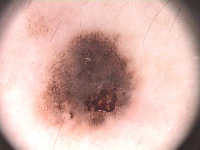</td><td>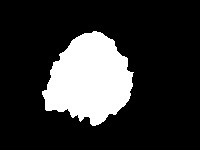</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [1]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2020-12-20 09:08:51--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2020-12-20 09:08:51--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc33086b4499f2a8055a650f35d9.dl.dropboxusercontent.com/cd/0/inline/BFZVfgdu5Z9x7PCzmCe0-_m_d7hCjCacXWyg3ZY7Lr5KuZjNX9sWDc0uPcpq0B0qi-gSCOWtxNmchcganIAmPy5-OgBmtczqyIi1uNwhsdkOUA/file# [following]
--2020-12-20 09:08:52--  https://uc33086b4499f2a8055a650f35d9.dl.dropboxusercontent.com/cd/0/inline/BFZVfgdu5Z9x7PCzmCe0-_m_d7hCjCacXWyg3ZY7Lr5KuZjNX9sWDc0uPcpq0B0qi-gSCOWtxNmchcganIAmPy5-OgBmtczqyIi1uNwhsdkOUA/file
Resolving 

In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

bad_data = ["417_", "210_", "411_", "424_", "240_", "413_"] # manual cleaning

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if any([data in root for data in bad_data]):
        continue
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import torch
import numpy as np

torch.manual_seed(42) #manual seed
np.random.seed(42)

X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 194 images


In [6]:
len(lesions)

194

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

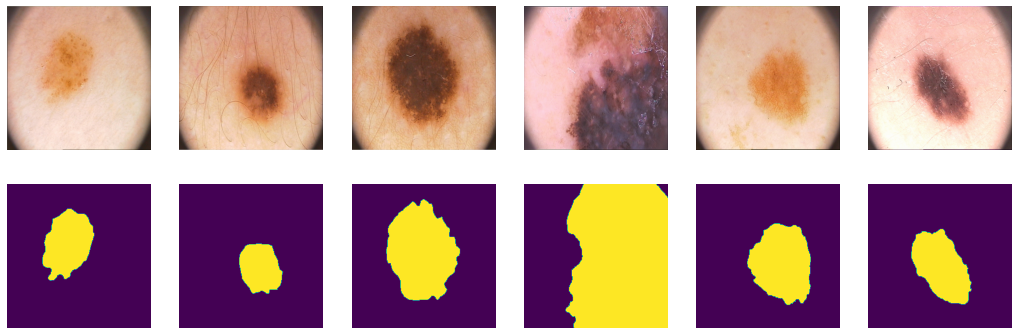

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50 (44 после чистки)
 для валидации и теста

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 44


#### PyTorch DataLoader

In [10]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

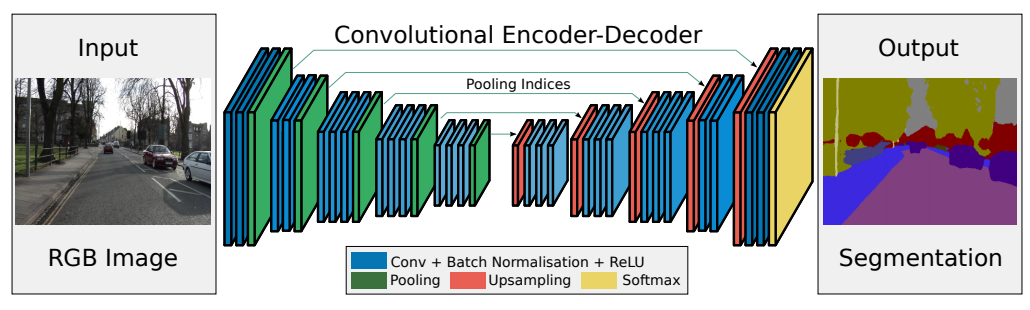

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [13]:
#https://github.com/salmanmaq/Conv-EncDec-PyTorch/blob/master/segnet.py

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv0_1_bn = nn.BatchNorm2d(64)
        self.enc_conv0_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv0_2_bn = nn.BatchNorm2d(64)
        self.pool0 = nn.MaxPool2d(2,2, return_indices = True) # 256 -> 128
        
        self.enc_conv1_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(128)
        self.enc_conv1_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2,2, return_indices = True) # 128 -> 64

        self.enc_conv2_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(256)
        self.enc_conv2_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(256)
        self.enc_conv2_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv2_3_bn = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2,2, return_indices = True) # 64 -> 32

        self.enc_conv3_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(512)
        self.enc_conv3_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(512)
        self.enc_conv3_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2,2, return_indices = True) # 32 -> 16

        self.enc_conv4_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.enc_conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.enc_conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2,2, return_indices = True,) # 16 -> 8

        # bottleneck
        # self.bottleneck_conv = 

        # decoder (upsampling)
        self.upsample4 = nn.MaxUnpool2d(2, 2)  # 8 -> 16
        self.dec_conv4_3 = nn.Conv2d (512, 512, 3, padding=1)
        self.dec_conv4_3_bn = nn.BatchNorm2d(512)
        self.dec_conv4_2 = nn.Conv2d (512, 512, 3, padding=1)
        self.dec_conv4_2_bn = nn.BatchNorm2d(512)
        self.dec_conv4_1 = nn.Conv2d (512, 512, 3, padding=1)
        self.dec_conv4_1_bn = nn.BatchNorm2d(512)

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3_3 = nn.Conv2d (512, 512, 3, padding=1)
        self.dec_conv3_3_bn = nn.BatchNorm2d(512)
        self.dec_conv3_2 = nn.Conv2d (512, 512, 3, padding=1)
        self.dec_conv3_2_bn = nn.BatchNorm2d(512)
        self.dec_conv3_1 = nn.Conv2d (512, 256, 3, padding=1)
        self.dec_conv3_1_bn = nn.BatchNorm2d(256) 

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2_3 = nn.Conv2d (256, 256, 3, padding=1)
        self.dec_conv2_3_bn = nn.BatchNorm2d(256)
        self.dec_conv2_2 = nn.Conv2d (256, 256, 3, padding=1)
        self.dec_conv2_2_bn = nn.BatchNorm2d(256)
        self.dec_conv2_1 = nn.Conv2d (256, 128, 3, padding=1)
        self.dec_conv2_1_bn = nn.BatchNorm2d(128) 

        self.upsample1 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv1_2 = nn.Conv2d (128, 128, 3, padding=1)
        self.dec_conv1_2_bn = nn.BatchNorm2d(128)
        self.dec_conv1_1 = nn.Conv2d (128, 64, 3, padding=1)
        self.dec_conv1_1_bn = nn.BatchNorm2d(64) 

        self.upsample0 = nn.MaxUnpool2d(2, 2)  # 128 -> 256
        self.dec_conv0_2 = nn.Conv2d (64, 64, 3, padding=1)
        self.dec_conv0_2_bn = nn.BatchNorm2d(64)
        self.dec_conv0_1 = nn.Conv2d (64, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0_1 = F.relu(self.conv0_1_bn(self.enc_conv0_1(x)))
        e0_2, id_0 = self.pool0(F.relu(self.conv0_2_bn(self.enc_conv0_2(e0_1))))

        e1_1 = F.relu(self.conv1_1_bn(self.enc_conv1_1(e0_2)))
        e1_2, id_1 = self.pool1(F.relu(self.conv1_2_bn(self.enc_conv1_2(e1_1))))

        e2_1 = F.relu(self.conv2_1_bn(self.enc_conv2_1(e1_2)))
        e2_2 = F.relu(self.conv2_2_bn(self.enc_conv2_2(e2_1)))
        e2_3, id_2 = self.pool2(F.relu(self.conv2_3_bn(self.enc_conv2_3(e2_2))))

        e3_1 = F.relu(self.conv3_1_bn(self.enc_conv3_1(e2_3)))
        e3_2 = F.relu(self.conv3_2_bn(self.enc_conv3_2(e3_1)))
        e3_3, id_3 = self.pool3(F.relu(self.conv3_3_bn(self.enc_conv3_3(e3_2))))

        e4_1 = F.relu(self.conv4_1_bn(self.enc_conv4_1(e3_3)))
        e4_2 = F.relu(self.conv4_2_bn(self.enc_conv4_2(e4_1)))
        e4_3, id_4 = self.pool3(F.relu(self.conv4_3_bn(self.enc_conv4_3(e4_2))))


        # bottleneck
        # b = 

        # decoder

        d4_3 = F.relu(self.dec_conv4_3_bn(self.dec_conv4_3(self.upsample4(e4_3, id_4)))) 
        d4_2 = F.relu(self.dec_conv4_2_bn(self.dec_conv4_2(d4_3))) 
        d4_1 = F.relu(self.dec_conv4_1_bn(self.dec_conv4_1(d4_2))) 

        d3_3 = F.relu(self.dec_conv3_3_bn(self.dec_conv3_3(self.upsample3(d4_1, id_3)))) 
        d3_2 = F.relu(self.dec_conv3_2_bn(self.dec_conv3_2(d3_3))) 
        d3_1 = F.relu(self.dec_conv3_1_bn(self.dec_conv3_1(d3_2))) 

        d2_3 = F.relu(self.dec_conv2_3_bn(self.dec_conv2_3(self.upsample2(d3_1, id_2)))) 
        d2_2 = F.relu(self.dec_conv2_2_bn(self.dec_conv2_2(d2_3)))  
        d2_1 = F.relu(self.dec_conv2_1_bn(self.dec_conv2_1(d2_2)))  

        d1_2 = F.relu(self.dec_conv1_2_bn(self.dec_conv1_2(self.upsample1(d2_1, id_1)))) 
        d1_1 = F.relu(self.dec_conv1_1_bn(self.dec_conv1_1(d1_2))) 

        d0_2 = F.relu(self.dec_conv0_2_bn(self.dec_conv0_2(self.upsample0(d1_1, id_0)))) 
        d0_1 = self.dec_conv0_1(d0_2) # no activation and BatchNorm
        
        return d0_1

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [14]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [15]:
def bce_loss(y_real, y_pred):
    return (y_pred - y_real*y_pred + torch.log(1+torch.exp(-y_pred))).mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [16]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, metric):
    X_val, Y_val = next(iter(data_val))

    train_loss = list()
    val_loss = list()
    train_accuracy = list()
    val_accuracy = list()

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        epoch_train_loss, epoch_train_accuracy = train_epoch(model, data_tr, opt, loss_fn, metric)
        train_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_accuracy)
        
        epoch_val_loss, epoch_val_accuracy = eval_epoch(model, data_val, loss_fn, metric)
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_accuracy)

        toc = time()

        # Visualize tools
        show_val_result(model, X_val, epoch, epochs, epoch_train_loss, epoch_val_loss)
        
    return [train_loss, val_loss, train_accuracy, val_accuracy] 

In [17]:
def show_val_result(model, X_val, epoch, epochs, train_loss, val_loss):
    """show intermediate results"""    
    model.eval() 
    Y_pred = model(X_val.to(device))
    Y_hat = Y_pred.to("cpu").detach().numpy() # detach and put into cpu

    clear_output(wait=True)

    for k in range(6):
        plt.subplot(2, 6, k+1)
        plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 6, k+7)
        plt.imshow(Y_hat[k, 0], cmap='gray')
        plt.title('Output')
        plt.axis('off')
    plt.suptitle('%d / %d - train_loss: %f, val_loss: %f' % (epoch+1, epochs, train_loss, val_loss))
    plt.show()

In [18]:
def train_epoch(model, data_tr, opt, loss_fn, metric):
    
    model.train() 
    train_loss = 0.0
    train_accuracy = 0.0

    for X_batch, Y_batch in data_tr:
        # data to device
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        # set parameter gradients to zero
        opt.zero_grad()
        # forward
        Y_pred = model(X_batch)
        loss = loss_fn(Y_batch, Y_pred)  # forward-pass
        loss.backward()  # backward-pass
        opt.step()  # update weights
        
        # calculate loss to show the user
        train_loss += float(loss.to("cpu").detach()) 
        preds = (Y_pred>0.5).int()
        train_accuracy += metric(preds, Y_batch.to(device)).mean().item()
    
    train_loss /= len(data_tr)
    train_accuracy /= len(data_tr)

    return train_loss, train_accuracy

In [19]:
def eval_epoch(model, data_val, criterion, metric):
   
    model.eval()    
    val_loss = 0.0
    val_accuracy = 0.0

    for X_val, Y_val in data_val:
        X_val = X_val.to(device)
        Y_val = Y_val.to(device)

        with torch.set_grad_enabled(False):
            Y_pred = model(X_val)
            loss = criterion(Y_val, Y_pred)
            preds = (Y_pred>0.5).int()
              
        val_loss += float(loss.to("cpu").detach())
        val_accuracy += metric(preds, Y_val.to(device)).mean().item()

    val_loss /= len(data_val)
    val_accuracy /= len(data_val)

    return val_loss, val_accuracy

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [20]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = model(data.to(device)) > 0.5
    return Y_pred

In [21]:
def score_model(model, metric, data, if_show = True):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = predict(model, X_batch)
        if (if_show):
            show(Y_label, Y_pred)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

In [22]:
def show (Y_label, Y_pred):
    Y_hat = Y_pred.to("cpu").detach().numpy() 
    Y_label = Y_label.to("cpu").detach().numpy()

    for k in range(min(6, Y_label.shape[0])):
        plt.subplot(2, 6, k+1)
        plt.imshow(Y_label[k, 0], cmap='gray')
        plt.title('Answer')
        plt.axis('off')

        plt.subplot(2, 6, k+7)
        plt.imshow(Y_hat[k, 0], cmap='gray')
        plt.title('Output')
        plt.axis('off')
    plt.show()

In [203]:
import matplotlib.pyplot as plt

def show_plot (data, plot_name, legend_names):
    plt.figure(figsize=(15, 8))
    plt.title(plot_name, {'size': 16})
    for i in data:
        plt.plot(i)
    plt.legend(legend_names, prop={'size': 12})
    plt.show()

In [459]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale = 1, rc=None)

def ShowBarPlot(history_score, name_prefix = ""):
    plt.figure(figsize=(18, 12))
    plt.title(name_prefix+" scores", {"size" : 12})

    df = pd.DataFrame(history_score, index=["train", "valid", "test"]).transpose()
    g = sns.barplot(y = df["train"], x = df.index,  palette="flare", alpha = 0.5)
    g = sns.barplot(y = df["test"], x = df.index,  palette="flare", alpha = 0.7)
    g = sns.barplot(y = df["valid"], x = df.index,  palette="flare", alpha = 1.0)
    

    for item in g.get_xticklabels():
        item.set_rotation(30)


    for ind, p in enumerate(g.patches):
        if (ind < len(g.patches)/3):
            g.annotate(str(format(p.get_height(), '.3f'))+"   train", 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', va = 'center', 
                          xytext = (0, 9), 
                          size=10,
                          textcoords = 'offset points')
        elif (ind >= len(g.patches)/3*2):
            g.annotate(str(format(p.get_height(), '.3f'))+"   valid", 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', va = 'center', 
                          xytext = (0, 9), 
                          size=10,
                          textcoords = 'offset points')
        else:
            g.annotate(str(format(p.get_height(), '.3f'))+"   test", 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', va = 'center', 
                          xytext = (0, 9), 
                          size=10,
                          textcoords = 'offset points')
        
        
    plt.xlabel("Accuracy", size=14)
    plt.ylabel("Model", size=14)

    plt.show()

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [23]:
model = SegNet().to(device)

In [24]:
history = {}
history_score = {}

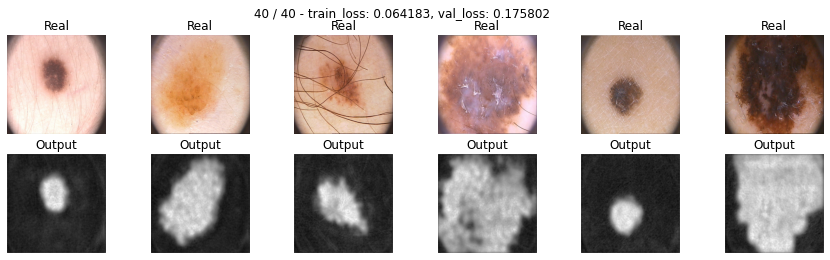

In [25]:
max_epochs = 40
optimaizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.02)
history["SegNet+bce_loss"] = train(model, optimaizer, bce_loss, max_epochs, data_tr, data_val, iou_pytorch)

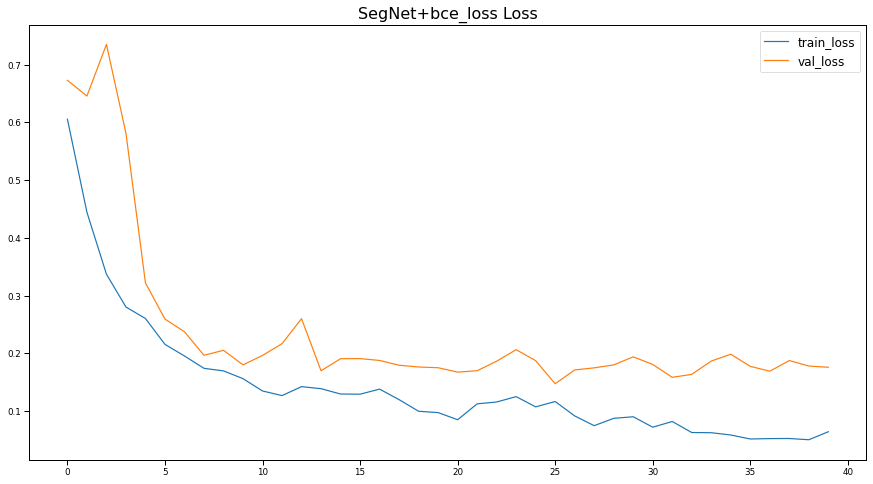

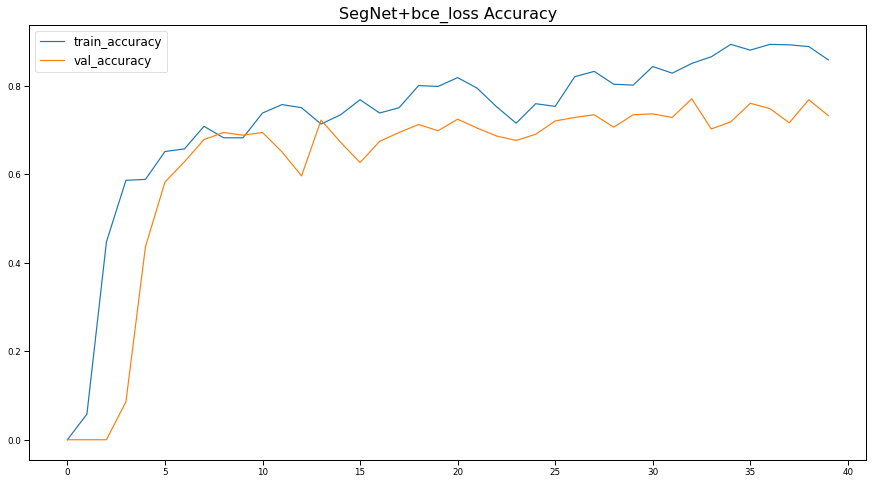

In [207]:
show_plot([history["SegNet+bce_loss"][0], history["SegNet+bce_loss"][1]], "SegNet+bce_loss Loss", ["train_loss", "val_loss"])
show_plot([history["SegNet+bce_loss"][2], history["SegNet+bce_loss"][3]], "SegNet+bce_loss Accuracy", ["train_accuracy", "val_accuracy"])

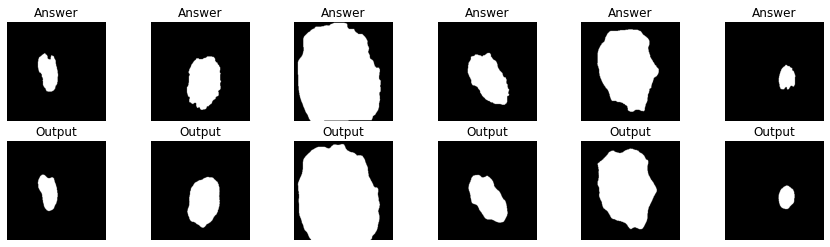

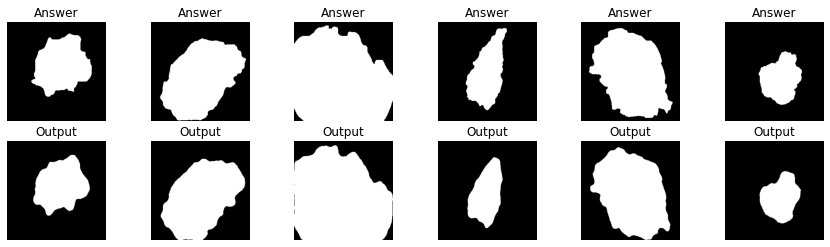

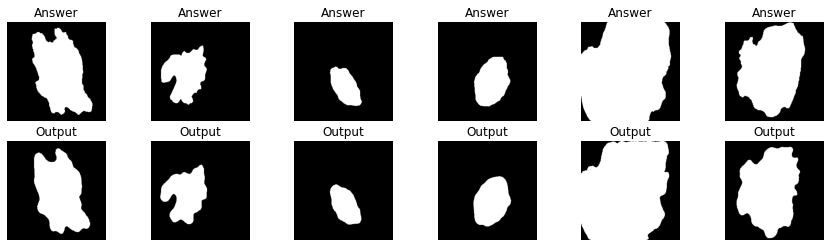

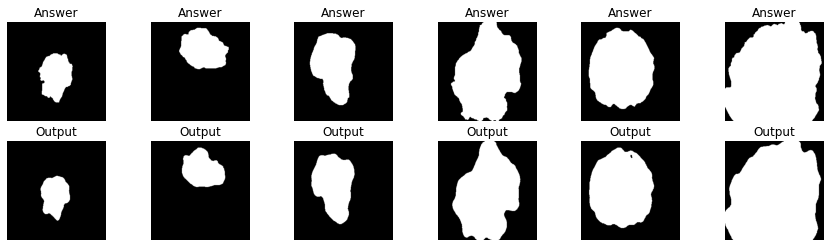

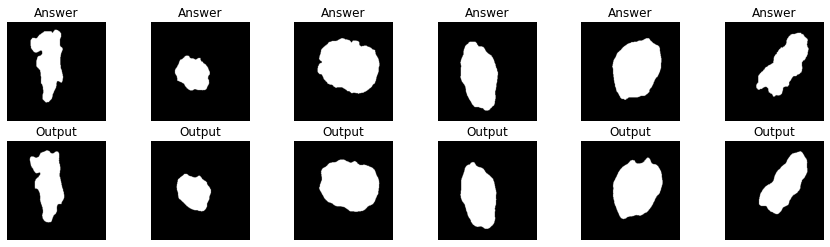

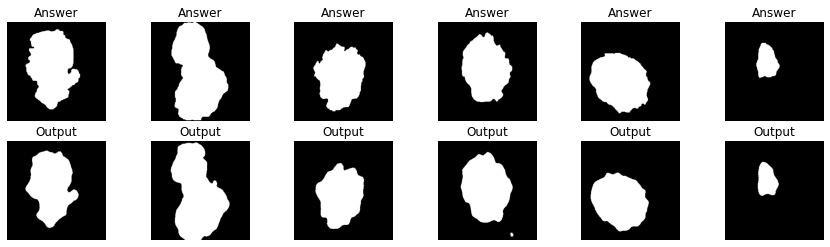

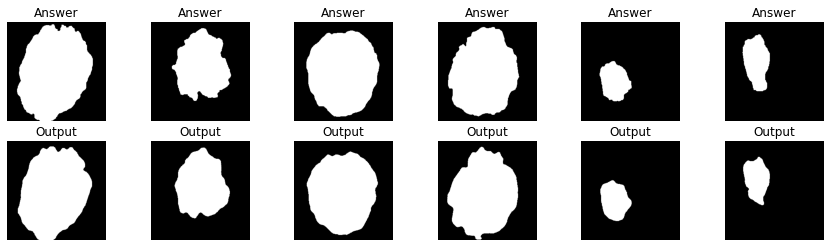

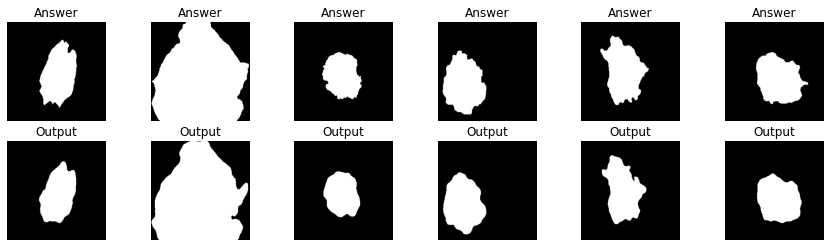

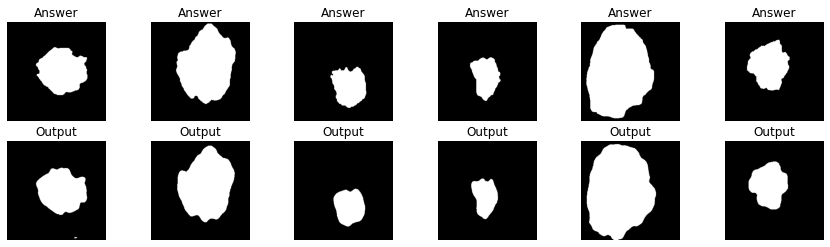

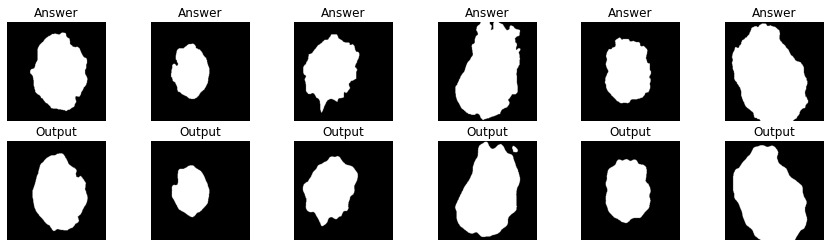

0.8830000519752502

In [28]:
score_model(model, iou_pytorch, data_tr)

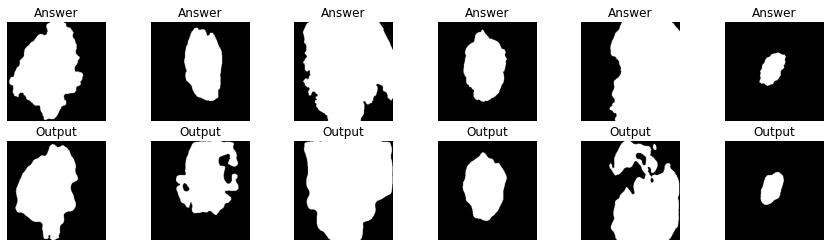

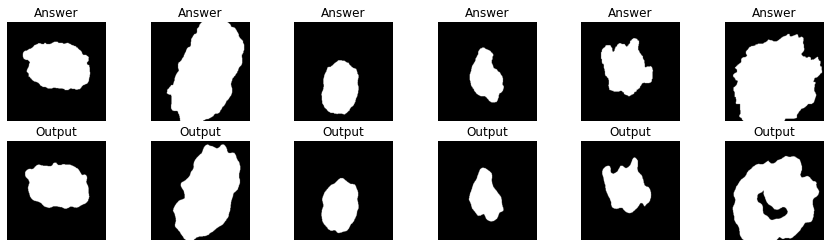

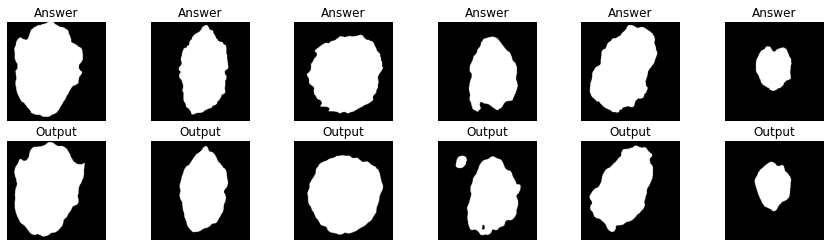

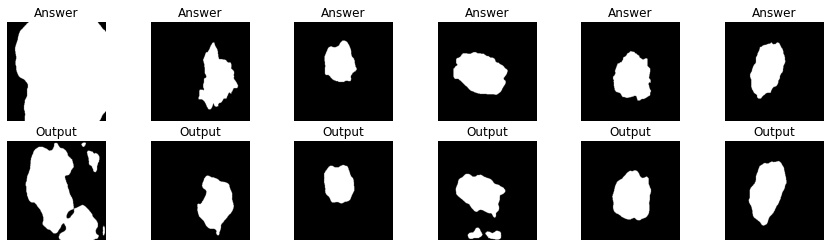

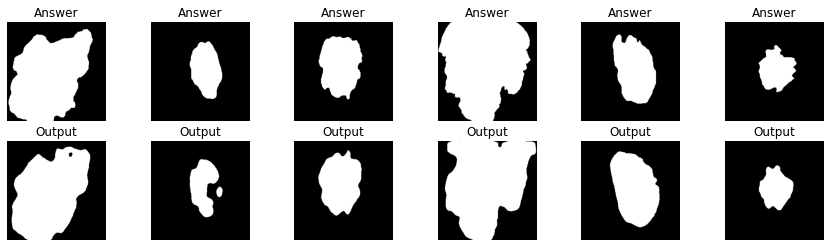

0.7320000052452087

In [29]:
score_model(model, iou_pytorch, data_val)

In [32]:
history_score["SegNet+bce_loss"] = [score_model(model, iou_pytorch, data_tr, if_show = False), 
                               score_model(model, iou_pytorch, data_val, if_show = False), 
                               score_model(model, iou_pytorch, data_ts, if_show = False)]

Ответьте себе на вопрос: не переобучается ли моя модель? - В какой-то момент (+-50 эпох) начинает переобучаться --> попробовать аугументацию

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало, прежде чем бить тревогу попробуйте поперебирать различные варианты, убедитесь, что во всех других сетапах сетть достигает желанного результата. СПОЙЛЕР: учиться она будеет при всех лоссах предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникаемой в математической формуле.


In [34]:
def dice_loss(y_real, y_pred):  

    smooth = 1e-2
    y_pred = 1/(1+torch.exp(-y_pred))
    
    intersection = 2*(y_pred*y_real)
    den = (y_pred+y_real)

    return 1 - ((intersection+smooth)/(den+smooth)).mean()

Проводим тестирование:

In [35]:
model_dice = SegNet().to(device)

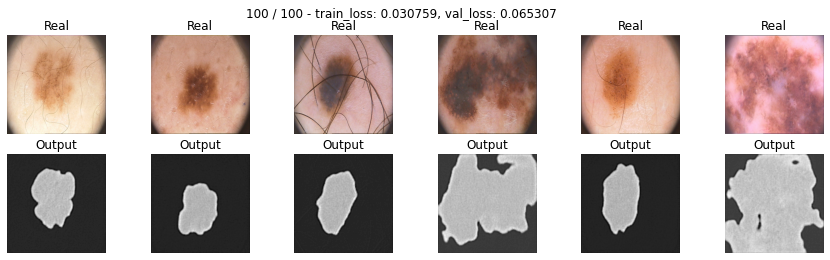

In [36]:
max_epochs = 100
optimaizer = optim.AdamW(model_dice.parameters(), lr=0.0001, weight_decay=0.02)
history["SegNet+dice_loss"] = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val, iou_pytorch)

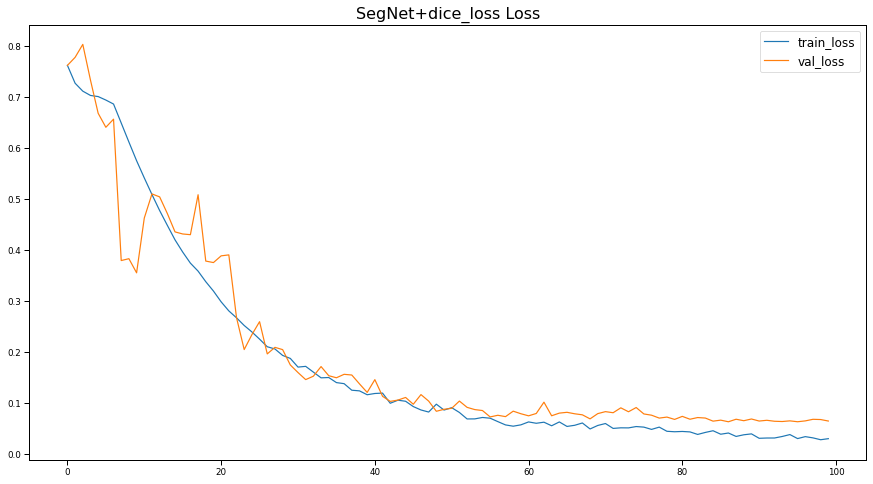

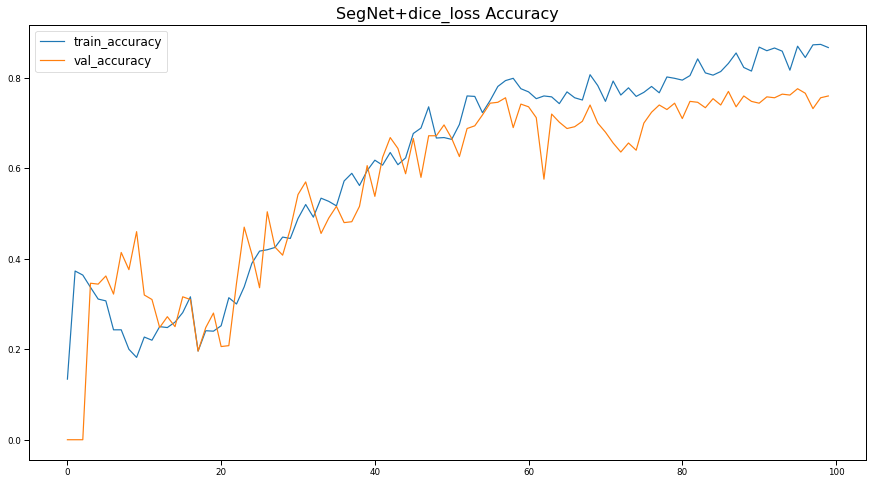

In [208]:
show_plot([history["SegNet+dice_loss"][0], history["SegNet+dice_loss"][1]], "SegNet+dice_loss Loss", ["train_loss", "val_loss"])
show_plot([history["SegNet+dice_loss"][2], history["SegNet+dice_loss"][3]], "SegNet+dice_loss Accuracy", ["train_accuracy", "val_accuracy"])

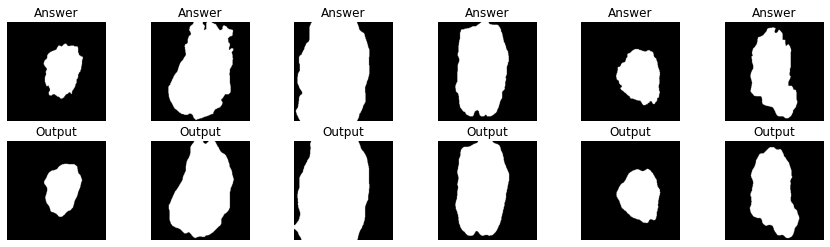

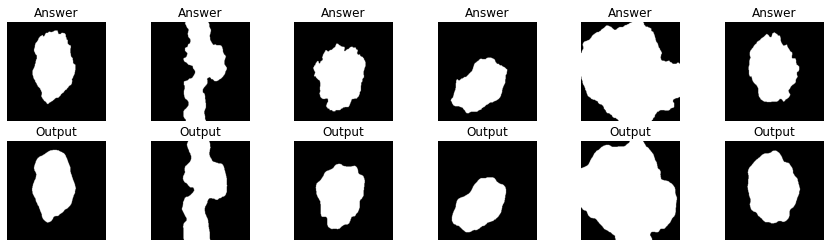

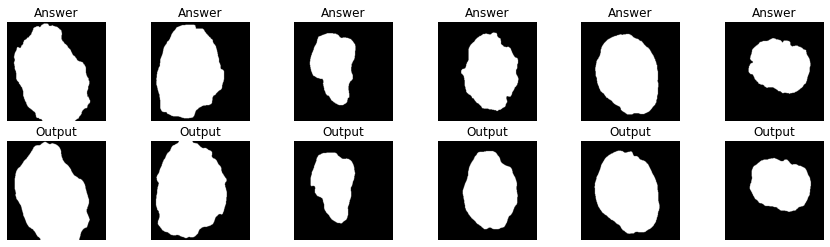

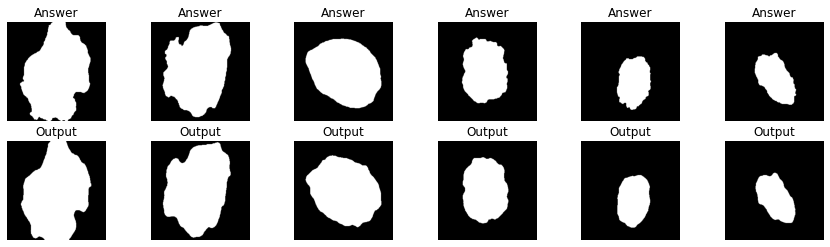

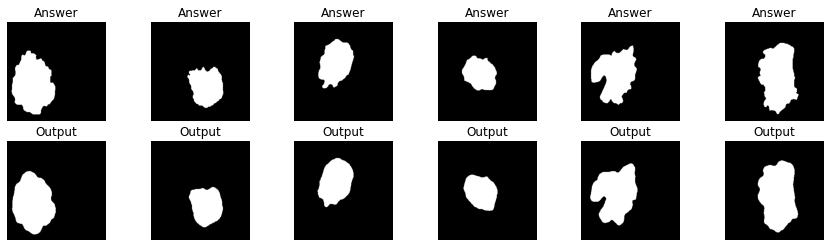

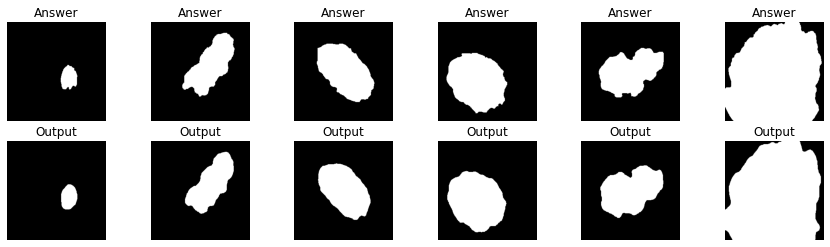

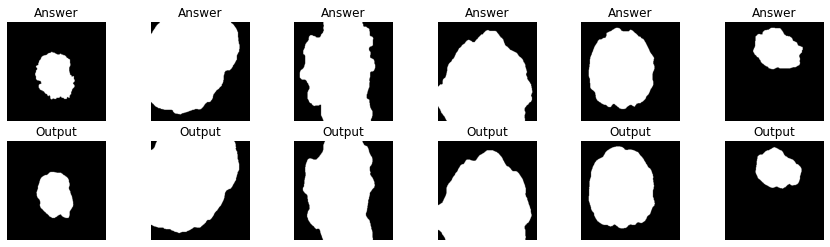

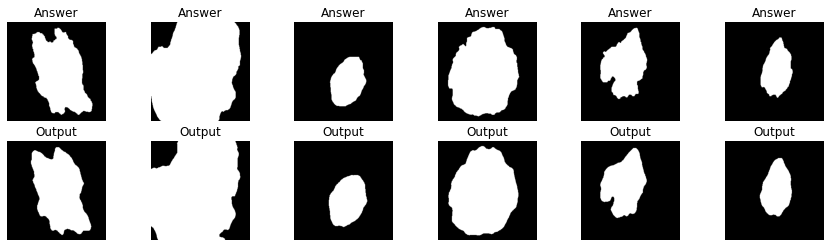

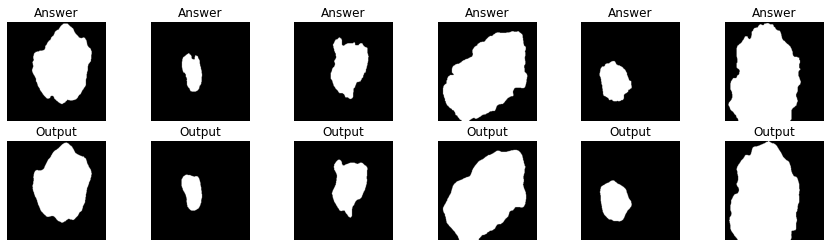

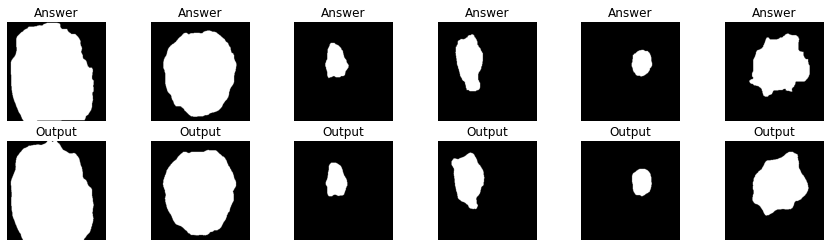

0.9140000164508819

In [44]:
score_model(model_dice, iou_pytorch, data_tr)

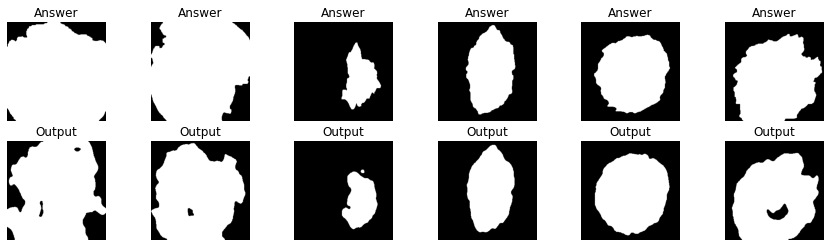

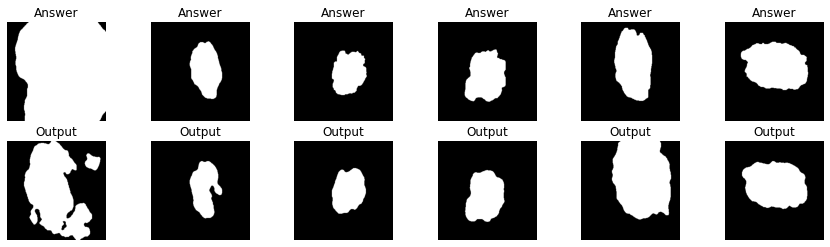

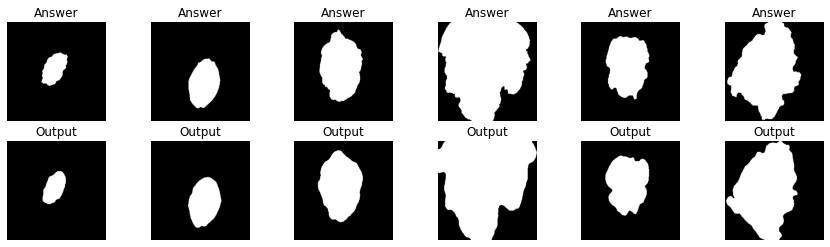

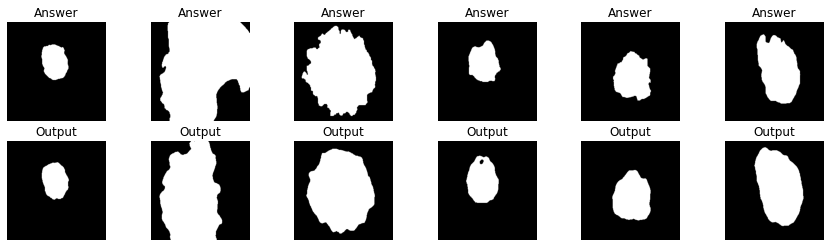

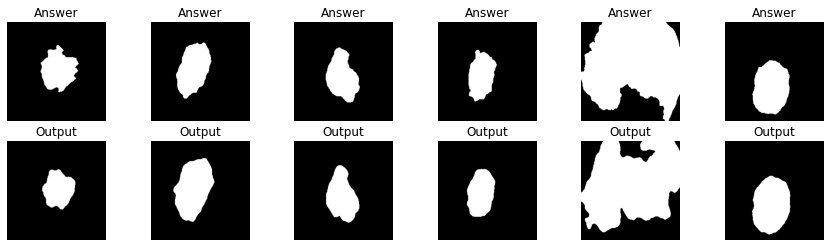

0.7600000381469727

In [45]:
score_model(model_dice, iou_pytorch, data_val)

In [48]:
history_score["SegNet+dice_loss"] = [score_model(model_dice, iou_pytorch, data_tr, if_show = False), 
                               score_model(model_dice, iou_pytorch, data_val, if_show = False), 
                               score_model(model_dice, iou_pytorch, data_ts, if_show = False)]

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [63]:
def focal_loss(y_real, y_pred, eps = 1e-2, gamma = 2):
    y_pred =  1/(1+torch.exp(-y_pred))
    return -(((1-y_pred)**gamma)*y_real*torch.log(y_pred+eps)+(1-y_real)*torch.log(1-y_pred+eps)).mean()


In [64]:
model_focal = SegNet().to(device)

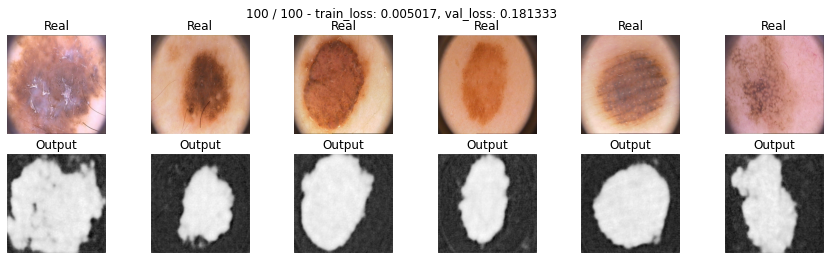

In [65]:
max_epochs = 100
optimaizer = optim.AdamW(model_focal.parameters(), lr=0.0001, weight_decay=0.02)
history["SegNet+focal_loss"] = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val, iou_pytorch)

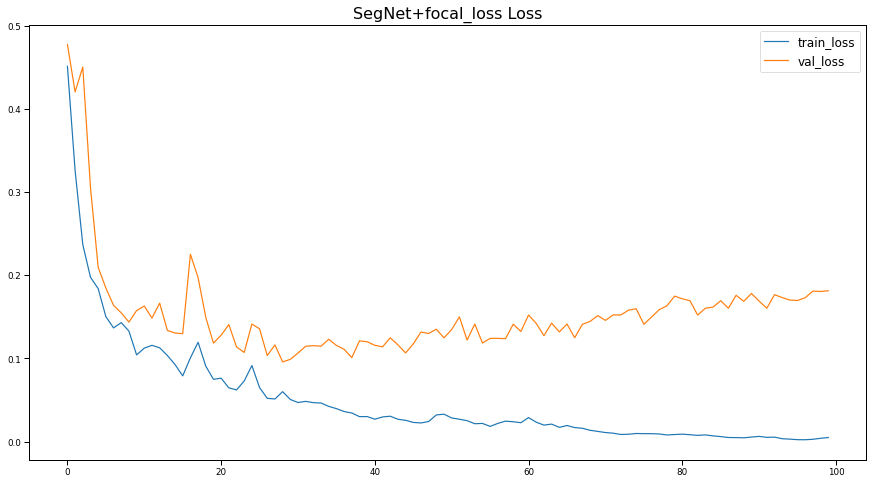

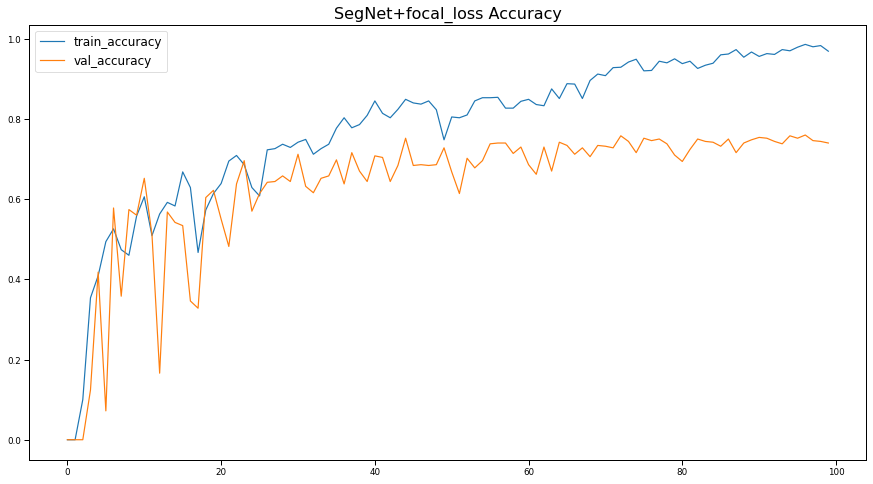

In [209]:
show_plot([history["SegNet+focal_loss"][0], history["SegNet+focal_loss"][1]], "SegNet+focal_loss Loss", ["train_loss", "val_loss"])
show_plot([history["SegNet+focal_loss"][2], history["SegNet+focal_loss"][3]], "SegNet+focal_loss Accuracy", ["train_accuracy", "val_accuracy"])

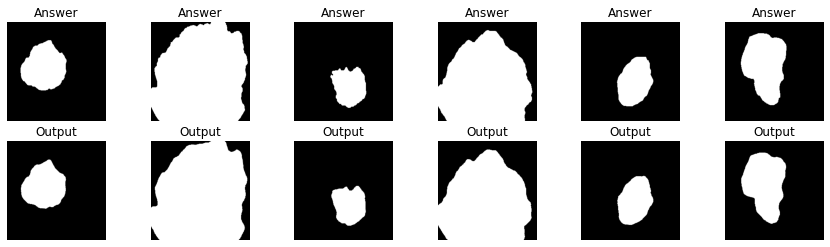

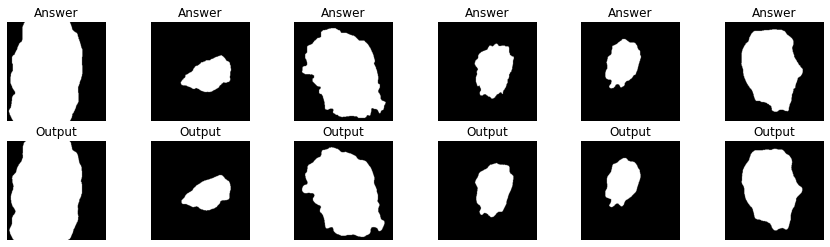

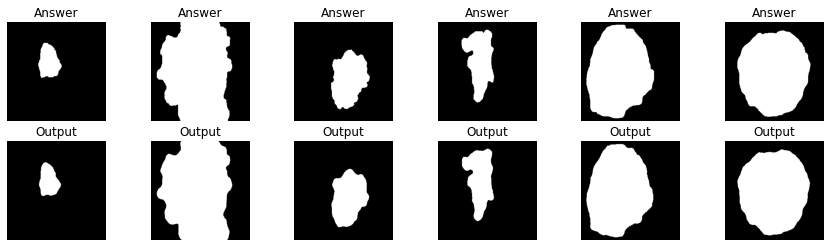

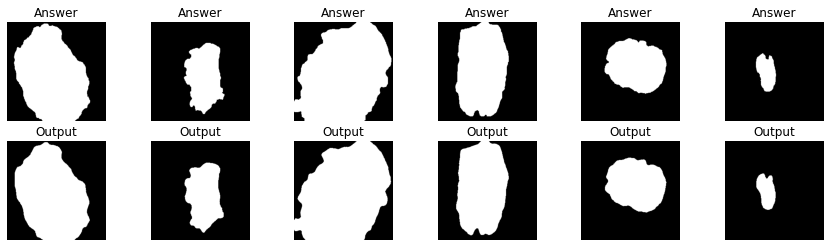

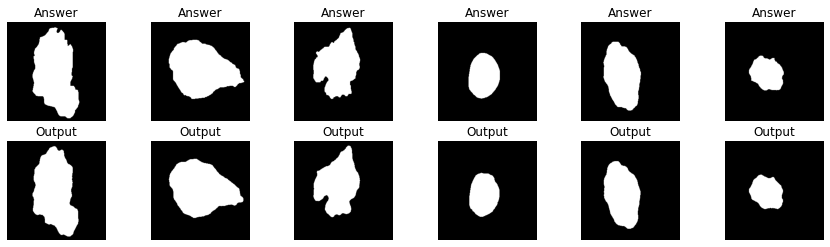

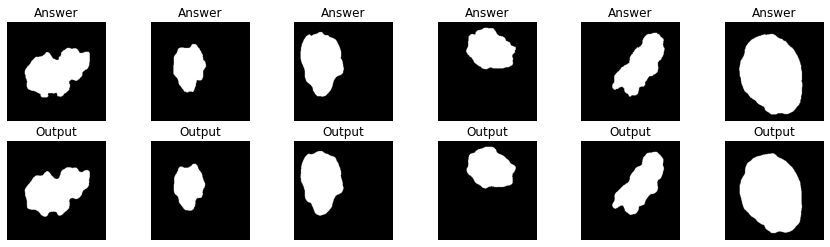

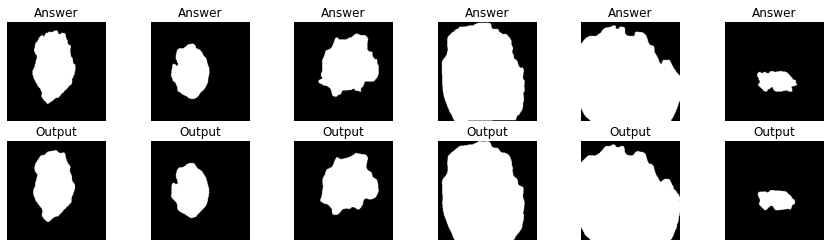

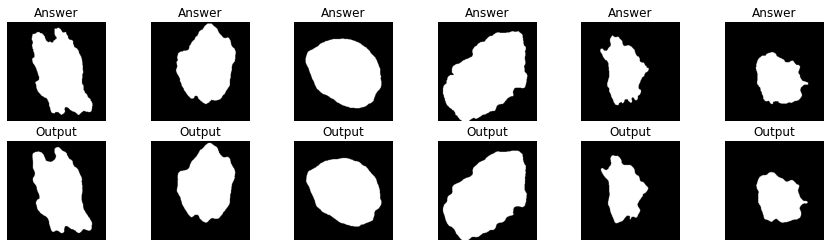

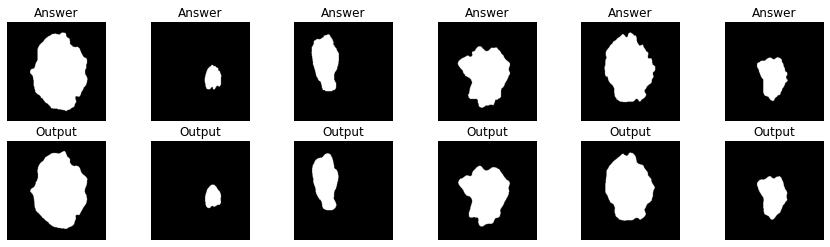

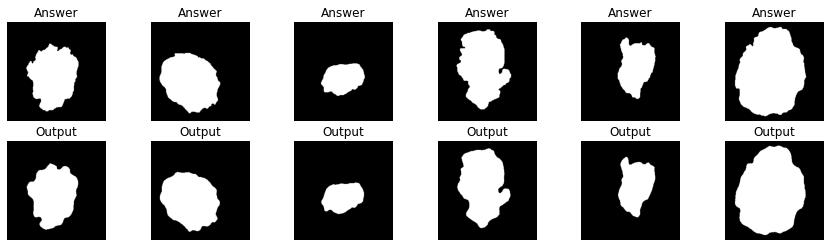

0.9800000071525574

In [72]:
score_model(model_focal, iou_pytorch, data_tr)

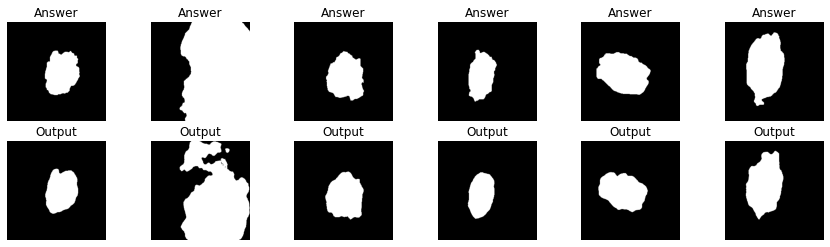

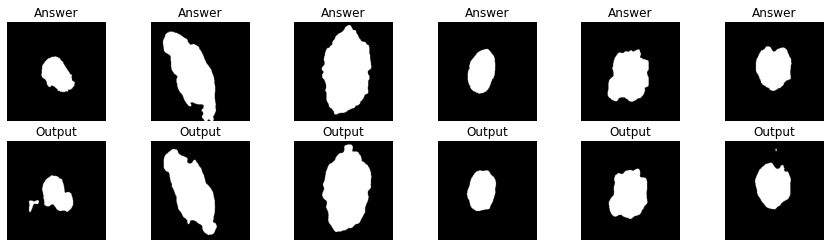

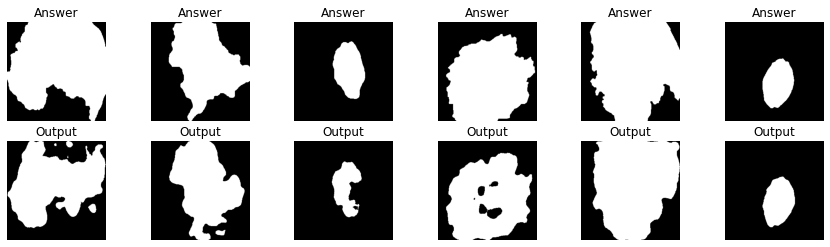

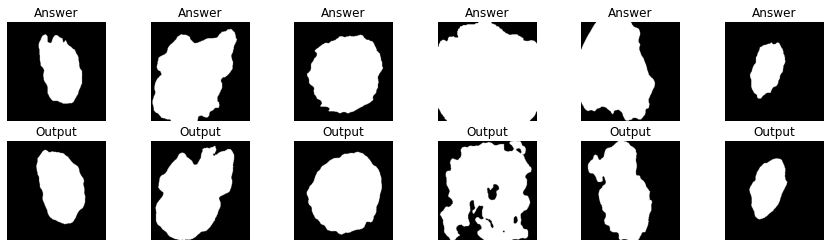

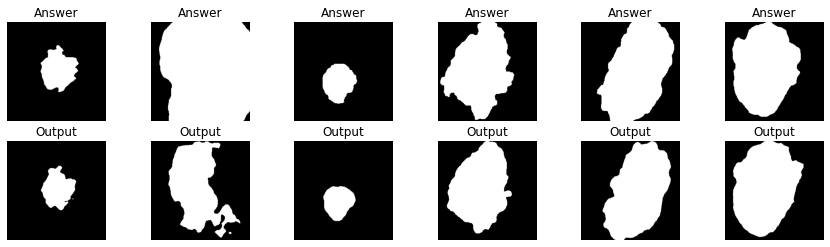

0.7400000095367432

In [73]:
score_model(model_focal, iou_pytorch, data_val)

In [70]:
history_score["SegNet+focal_loss"] = [score_model(model_focal, iou_pytorch, data_tr, if_show = False), 
                               score_model(model_focal, iou_pytorch, data_val, if_show = False), 
                               score_model(model_focal, iou_pytorch, data_ts, if_show = False)]

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [181]:
def L2_loss(y_real, y_pred):  
    return ((y_pred-y_real)**2).mean()

In [182]:
model_L2 = SegNet().to(device)

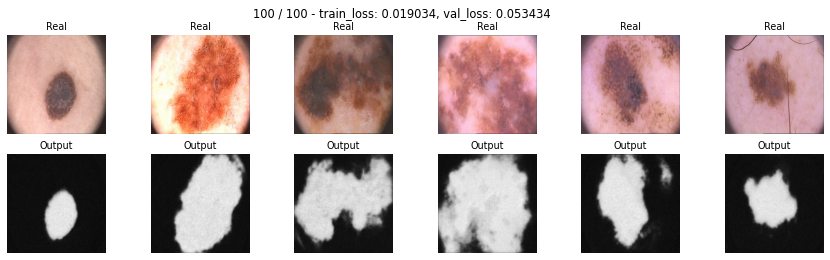

In [183]:
max_epochs = 100
optimaizer = optim.AdamW(model_L2.parameters(), lr=0.0003, weight_decay=0.02)
history["model_L2"] = train(model_L2, optimaizer, L2_loss, max_epochs, data_tr, data_val, iou_pytorch)

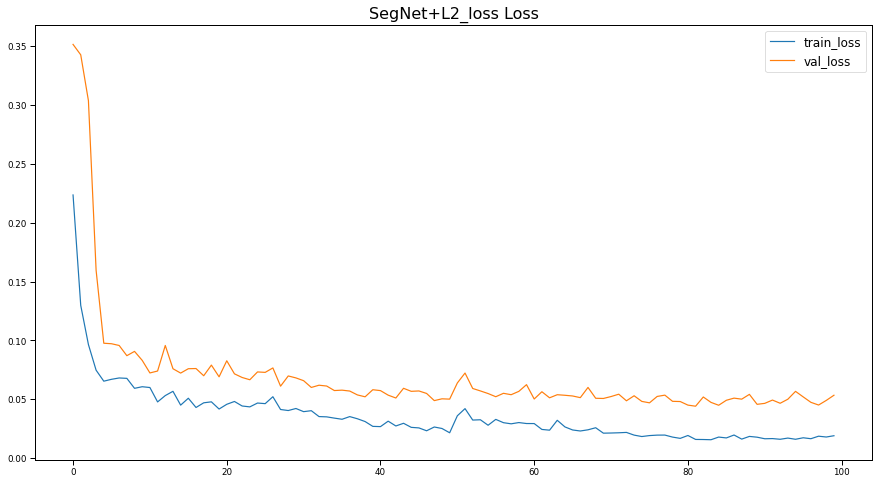

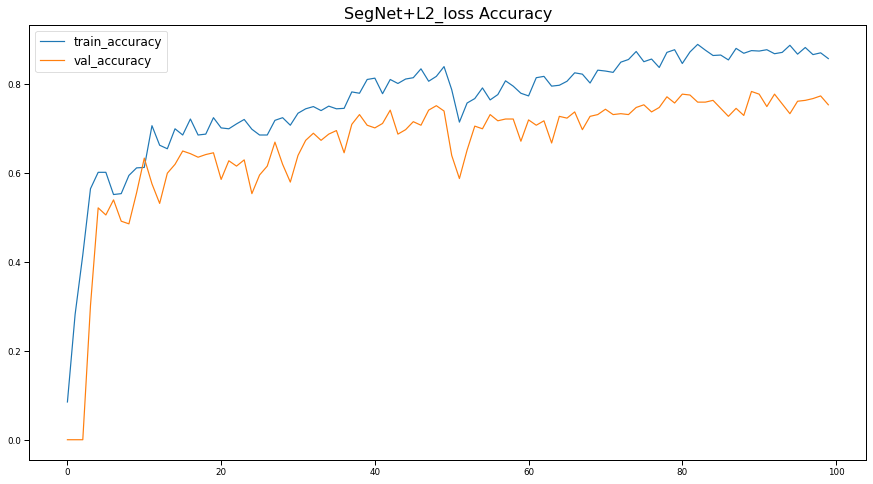

In [210]:
show_plot([history["model_L2"][0], history["model_L2"][1]], "SegNet+L2_loss Loss", ["train_loss", "val_loss"])
show_plot([history["model_L2"][2], history["model_L2"][3]], "SegNet+L2_loss Accuracy", ["train_accuracy", "val_accuracy"])

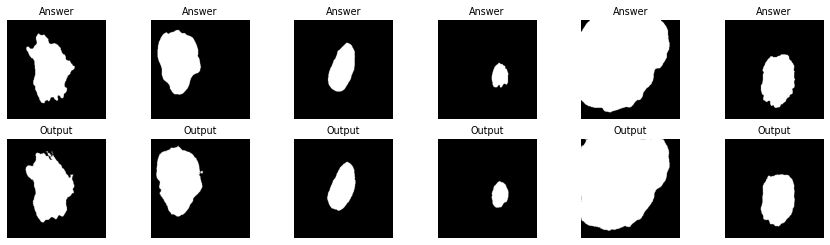

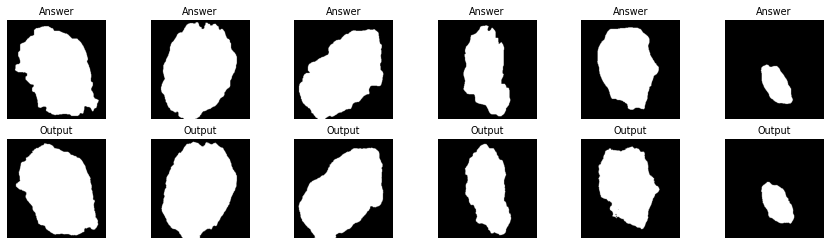

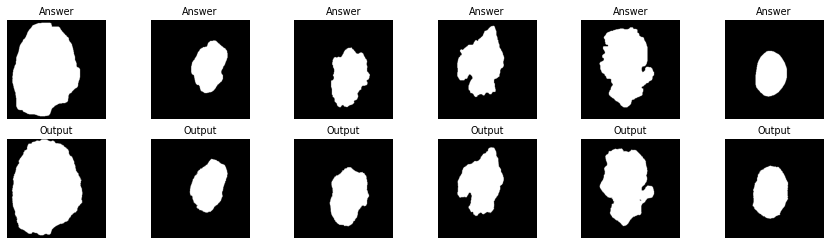

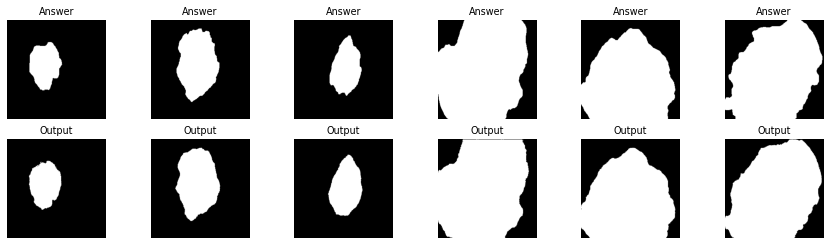

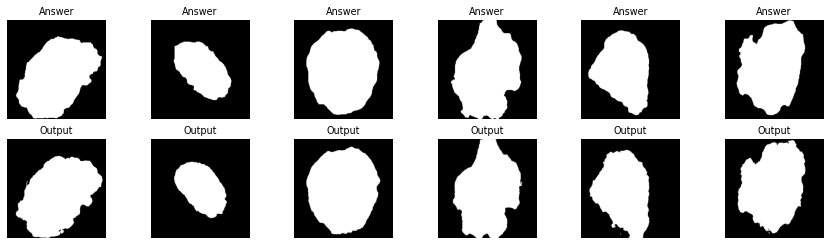

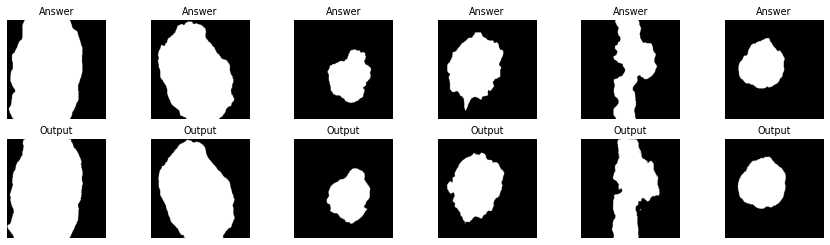

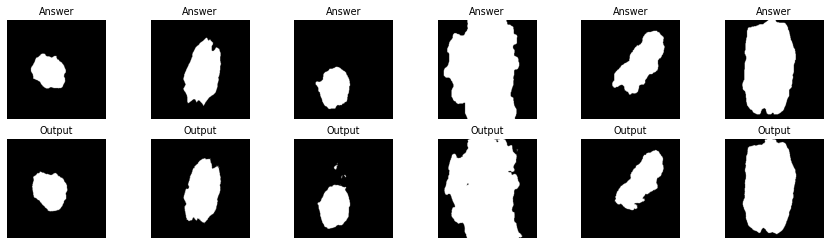

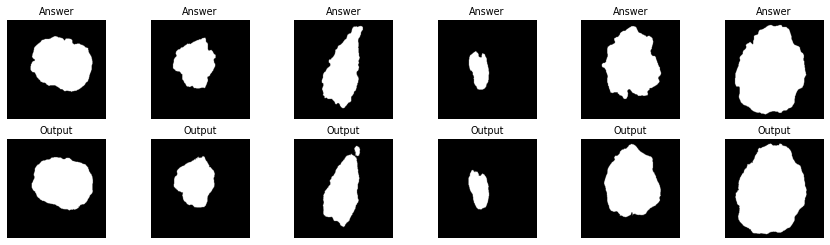

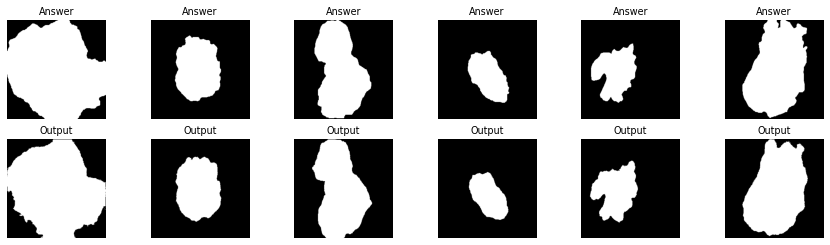

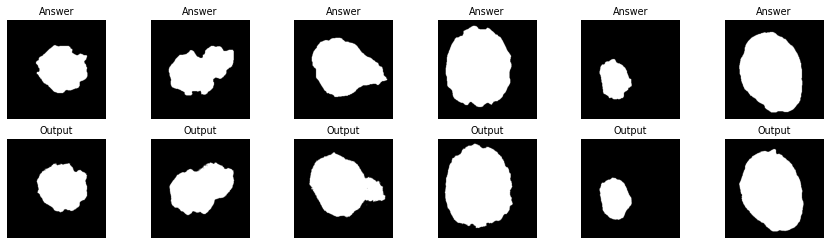

0.8940000414848328

In [186]:
score_model(model_L2, iou_pytorch, data_tr)

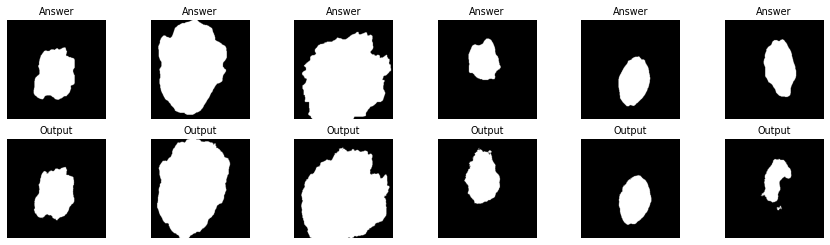

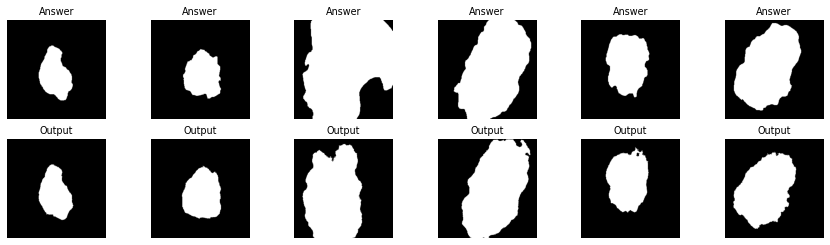

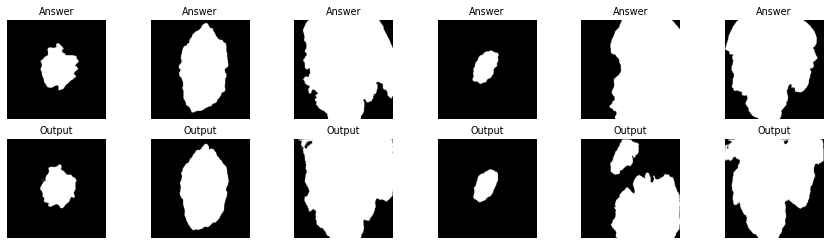

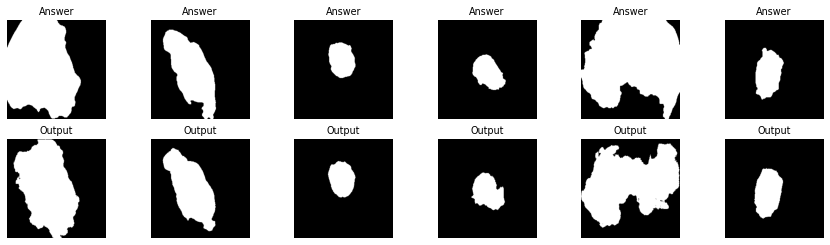

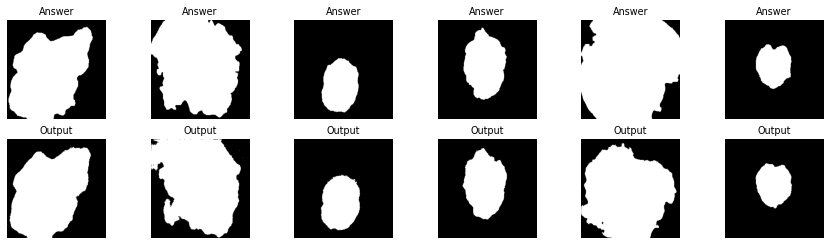

0.7540000438690185

In [187]:
score_model(model_L2, iou_pytorch, data_val)

In [188]:
history_score["SegNet+L2_loss"] = [score_model(model_L2, iou_pytorch, data_tr, if_show = False), 
                               score_model(model_L2, iou_pytorch, data_val, if_show = False), 
                               score_model(model_L2, iou_pytorch, data_ts, if_show = False)]

## HausdorffDTLoss

In [199]:
from scipy.ndimage.morphology import distance_transform_edt as edt

@torch.no_grad()
def distance_field(img: np.ndarray) -> np.ndarray:
    field = np.zeros_like(img)

    for batch in range(len(img)):
        fg_mask = img[batch] > 0.5

        if fg_mask.any():
            bg_mask = ~fg_mask
            
            fg_dist = edt(fg_mask)
            bg_dist = edt(bg_mask)

            field[batch] = fg_dist + bg_dist

    return field

In [200]:
def HausdorffDTLoss(y_real, y_pred, alpha = 0.2): 
    
    y_pred_dt = torch.from_numpy(distance_field(y_pred.to("cpu").detach().numpy())).float()
    y_real_dt = torch.from_numpy(distance_field(y_real.to("cpu").detach().numpy())).float()

    y_pred_dt = y_pred_dt.to(device)
    y_real_dt = y_real_dt.to(device)

    pred_error = (y_pred - y_real) ** 2
    distance = y_pred_dt ** alpha + y_real_dt ** alpha
    dt_field = pred_error * distance
    loss = dt_field.mean()
    return loss

In [201]:
model_HausdorffDT = SegNet().to(device)

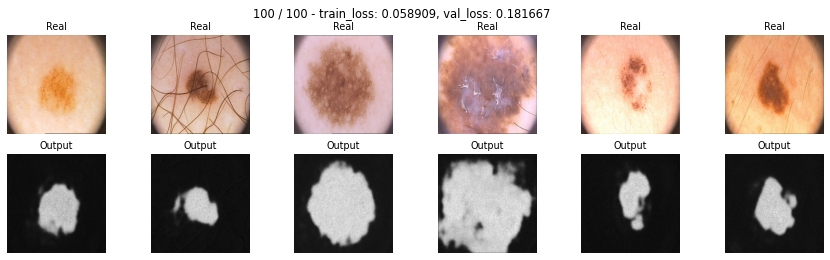

In [202]:
max_epochs = 100
optimaizer = optim.AdamW(model_HausdorffDT.parameters(), lr=0.0001, weight_decay=0.02)
history["SegNet+HausdorffDT_loss"] = train(model_HausdorffDT, optimaizer, HausdorffDTLoss, max_epochs, data_tr, data_val, iou_pytorch)

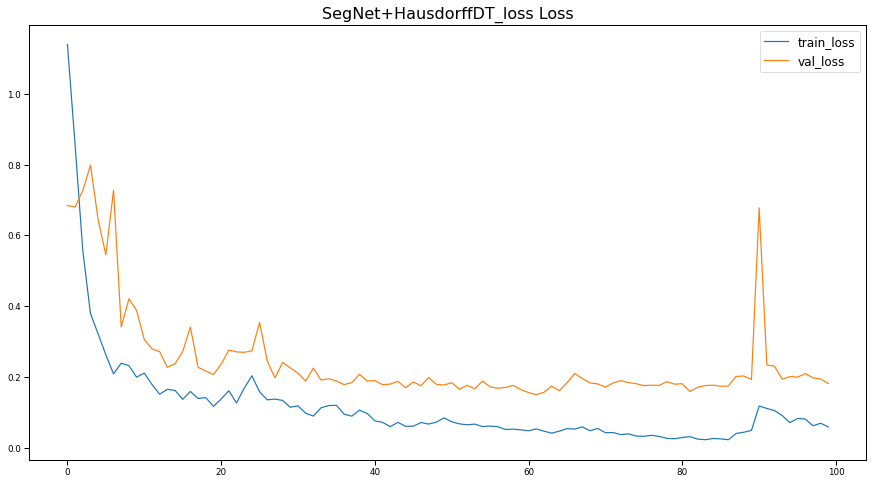

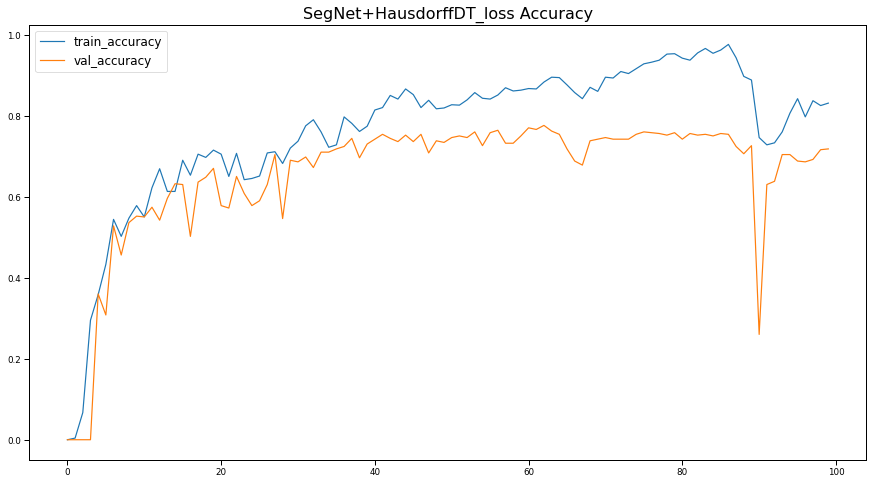

In [211]:
show_plot([history["SegNet+HausdorffDT_loss"][0], history["SegNet+HausdorffDT_loss"][1]], "SegNet+HausdorffDT_loss Loss", ["train_loss", "val_loss"])
show_plot([history["SegNet+HausdorffDT_loss"][2], history["SegNet+HausdorffDT_loss"][3]], "SegNet+HausdorffDT_loss Accuracy", ["train_accuracy", "val_accuracy"])

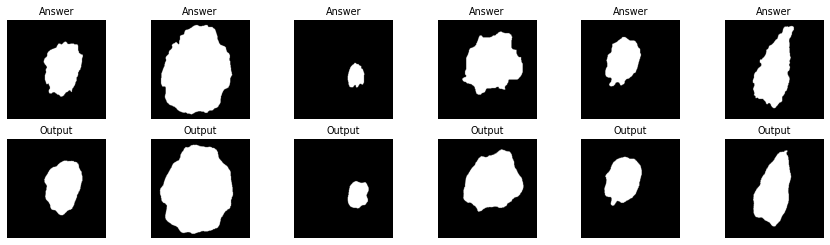

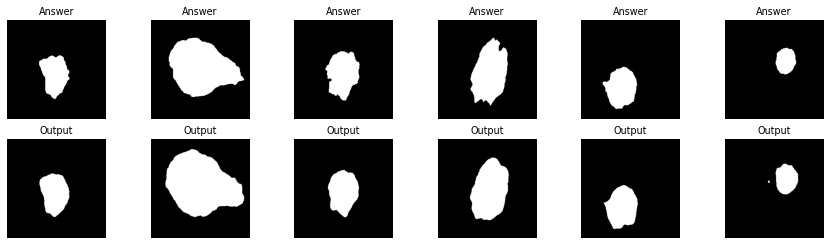

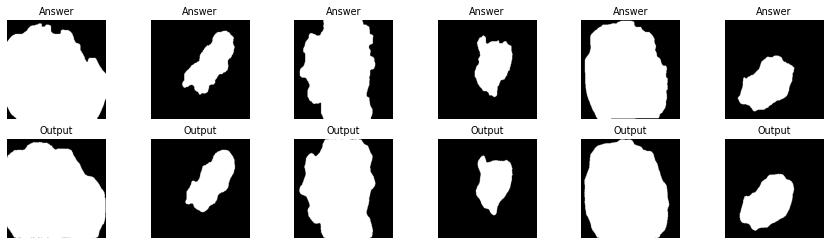

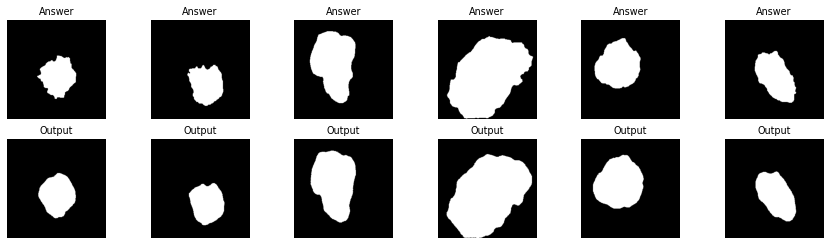

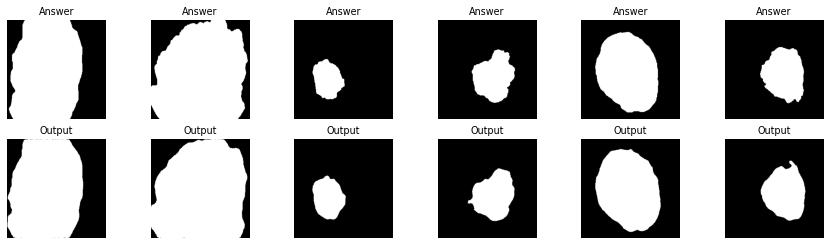

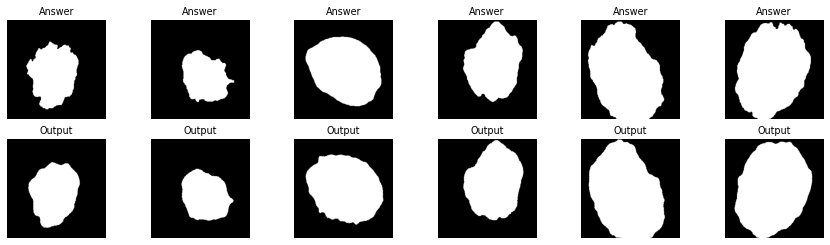

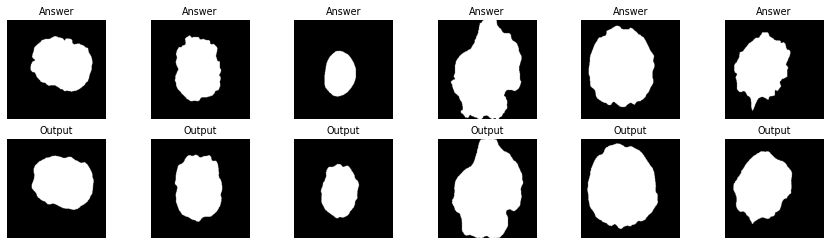

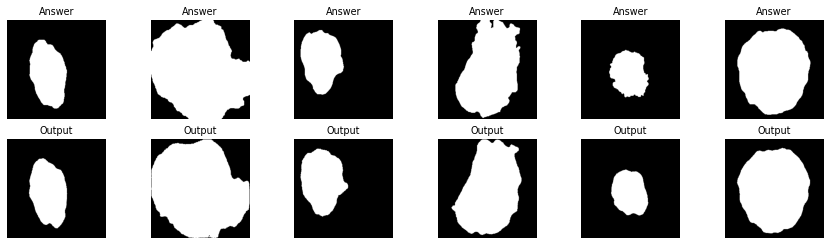

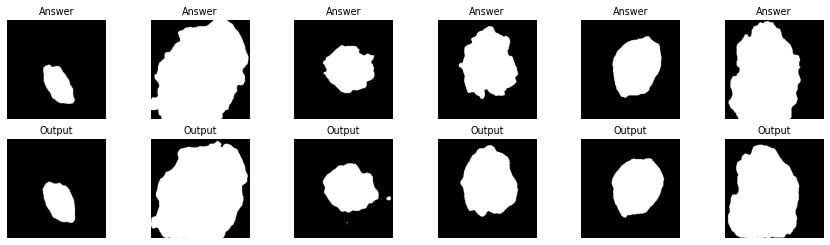

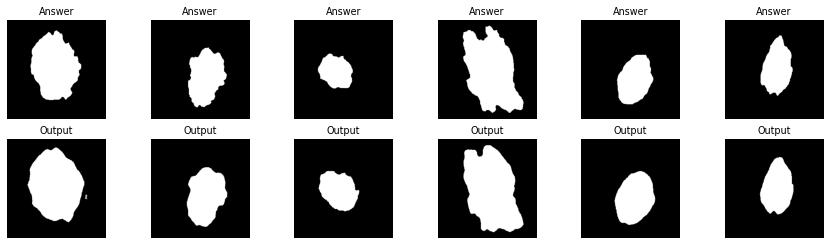

0.859000051021576

In [212]:
score_model(model_HausdorffDT, iou_pytorch, data_tr)

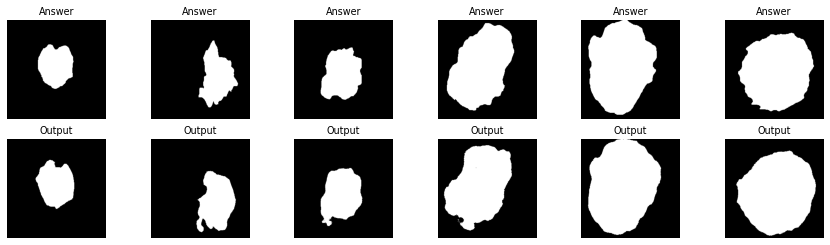

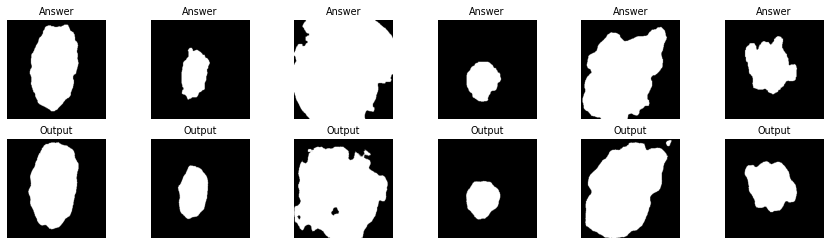

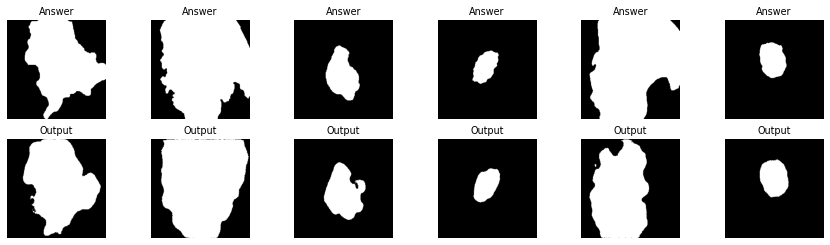

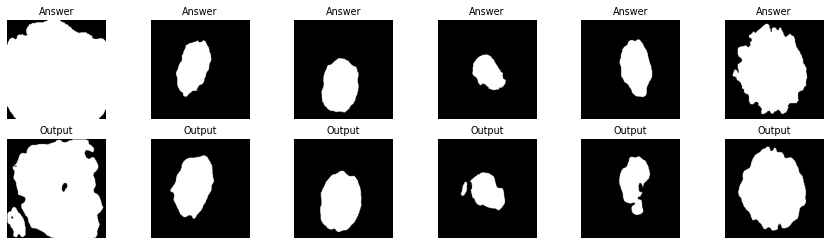

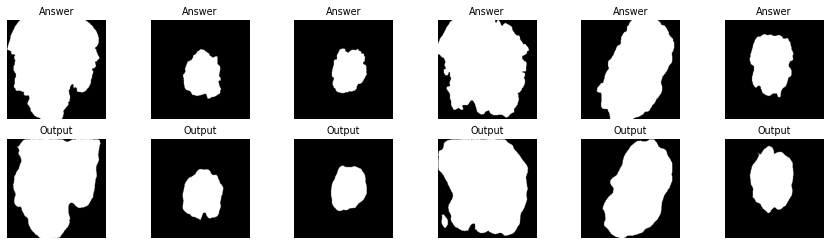

0.7180000424385071

In [213]:
score_model(model_HausdorffDT, iou_pytorch, data_val)

In [214]:
history_score["SegNet+HausdorffDT_loss"] = [score_model(model_HausdorffDT, iou_pytorch, data_tr, if_show = False), 
                               score_model(model_HausdorffDT, iou_pytorch, data_val, if_show = False), 
                               score_model(model_HausdorffDT, iou_pytorch, data_ts, if_show = False)]

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

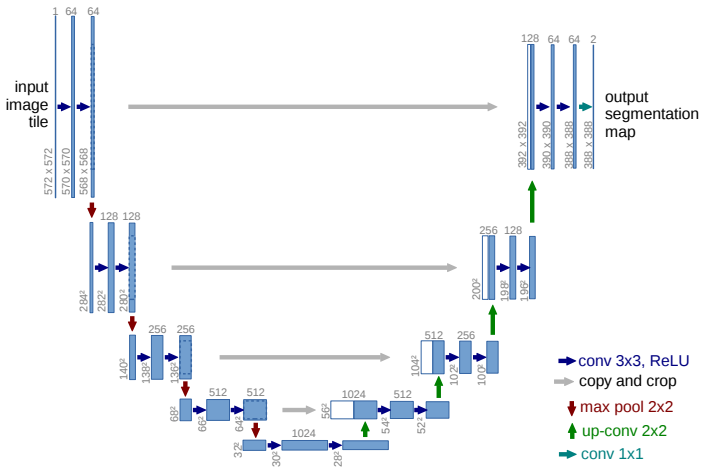

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [242]:
class UNet(nn.Module):

    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv0_1_bn = nn.BatchNorm2d(64)
        self.enc_conv0_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv0_2_bn = nn.BatchNorm2d(64)
        self.pool0 = nn.MaxPool2d(2,2, return_indices = True) # 256 -> 128
        
        self.enc_conv1_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(128)
        self.enc_conv1_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2,2, return_indices = True) # 128 -> 64

        self.enc_conv2_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(256)
        self.enc_conv2_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(256)
        self.enc_conv2_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv2_3_bn = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2,2, return_indices = True) # 64 -> 32

        self.enc_conv3_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(512)
        self.enc_conv3_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(512)
        self.enc_conv3_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2,2, return_indices = True) # 32 -> 16

        self.enc_conv4_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.enc_conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.enc_conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2,2, return_indices = True,) # 16 -> 8

        # bottleneck
        # self.bottleneck_conv = 

        # decoder (upsampling)
        self.upsample4 = nn.MaxUnpool2d(2, 2)  # 8 -> 16
        self.dec_conv4_3 = nn.Conv2d (512, 512, 3, padding=1)
        self.dec_conv4_3_bn = nn.BatchNorm2d(512)
        self.dec_conv4_2 = nn.Conv2d (512, 512, 3, padding=1)
        self.dec_conv4_2_bn = nn.BatchNorm2d(512)
        self.dec_conv4_1 = nn.Conv2d (512, 512, 3, padding=1)
        self.dec_conv4_1_bn = nn.BatchNorm2d(512)

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3_3 = nn.Conv2d (512, 512, 3, padding=1)
        self.dec_conv3_3_bn = nn.BatchNorm2d(512)
        self.dec_conv3_2 = nn.Conv2d (512, 512, 3, padding=1)
        self.dec_conv3_2_bn = nn.BatchNorm2d(512)
        self.dec_conv3_1 = nn.Conv2d (512, 256, 3, padding=1)
        self.dec_conv3_1_bn = nn.BatchNorm2d(256) 

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2_3 = nn.Conv2d (256, 256, 3, padding=1)
        self.dec_conv2_3_bn = nn.BatchNorm2d(256)
        self.dec_conv2_2 = nn.Conv2d (256, 256, 3, padding=1)
        self.dec_conv2_2_bn = nn.BatchNorm2d(256)
        self.dec_conv2_1 = nn.Conv2d (256, 128, 3, padding=1)
        self.dec_conv2_1_bn = nn.BatchNorm2d(128) 

        self.upsample1 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv1_2 = nn.Conv2d (128, 128, 3, padding=1)
        self.dec_conv1_2_bn = nn.BatchNorm2d(128)
        self.dec_conv1_1 = nn.Conv2d (128, 64, 3, padding=1)
        self.dec_conv1_1_bn = nn.BatchNorm2d(64) 

        self.upsample0 = nn.MaxUnpool2d(2, 2)  # 128 -> 256
        self.dec_conv0_2 = nn.Conv2d (64, 64, 3, padding=1)
        self.dec_conv0_2_bn = nn.BatchNorm2d(64)
        self.dec_conv0_1 = nn.Conv2d (64, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0_1 = F.relu(self.conv0_1_bn(self.enc_conv0_1(x)))
        sk_0 = F.relu(self.conv0_2_bn(self.enc_conv0_2(e0_1)))
        e0_2, id_0 = self.pool0(sk_0)

        e1_1 = F.relu(self.conv1_1_bn(self.enc_conv1_1(e0_2)))
        sk_1 = F.relu(self.conv1_2_bn(self.enc_conv1_2(e1_1)))
        e1_2, id_1 = self.pool1(sk_1)

        e2_1 = F.relu(self.conv2_1_bn(self.enc_conv2_1(e1_2)))
        e2_2 = F.relu(self.conv2_2_bn(self.enc_conv2_2(e2_1)))
        sk_2 = F.relu(self.conv2_3_bn(self.enc_conv2_3(e2_2)))
        e2_3, id_2 = self.pool2(sk_2)

        e3_1 = F.relu(self.conv3_1_bn(self.enc_conv3_1(e2_3)))
        e3_2 = F.relu(self.conv3_2_bn(self.enc_conv3_2(e3_1)))
        sk_3 = F.relu(self.conv3_3_bn(self.enc_conv3_3(e3_2)))
        e3_3, id_3 = self.pool3(sk_3)

        e4_1 = F.relu(self.conv4_1_bn(self.enc_conv4_1(e3_3)))
        e4_2 = F.relu(self.conv4_2_bn(self.enc_conv4_2(e4_1)))
        e4_3, id_4 = self.pool4(F.relu(self.conv4_3_bn(self.enc_conv4_3(e4_2))))


        # bottleneck
        # b = 

        # decoder

        d4_3 = F.relu(self.dec_conv4_3_bn(self.dec_conv4_3(self.upsample4(e4_3, id_4)))) 
        d4_2 = F.relu(self.dec_conv4_2_bn(self.dec_conv4_2(d4_3))) 
        d4_1 = F.relu(self.dec_conv4_1_bn(self.dec_conv4_1(d4_2))) 

        d3_3 = F.relu(self.dec_conv3_3_bn(self.dec_conv3_3(self.upsample3(d4_1, id_3)+sk_3))) 
        d3_2 = F.relu(self.dec_conv3_2_bn(self.dec_conv3_2(d3_3))) 
        d3_1 = F.relu(self.dec_conv3_1_bn(self.dec_conv3_1(d3_2))) 

        d2_3 = F.relu(self.dec_conv2_3_bn(self.dec_conv2_3(self.upsample2(d3_1, id_2)+sk_2))) 
        d2_2 = F.relu(self.dec_conv2_2_bn(self.dec_conv2_2(d2_3)))  
        d2_1 = F.relu(self.dec_conv2_1_bn(self.dec_conv2_1(d2_2)))  

        d1_2 = F.relu(self.dec_conv1_2_bn(self.dec_conv1_2(self.upsample1(d2_1, id_1)+sk_1))) 
        d1_1 = F.relu(self.dec_conv1_1_bn(self.dec_conv1_1(d1_2))) 

        d0_2 = F.relu(self.dec_conv0_2_bn(self.dec_conv0_2(self.upsample0(d1_1, id_0)+sk_0))) 
        d0_1 = self.dec_conv0_1(d0_2) # no activation and BatchNorm
        
        return d0_1

##Unet+bce_loss

In [243]:
unet_model = UNet().to(device)

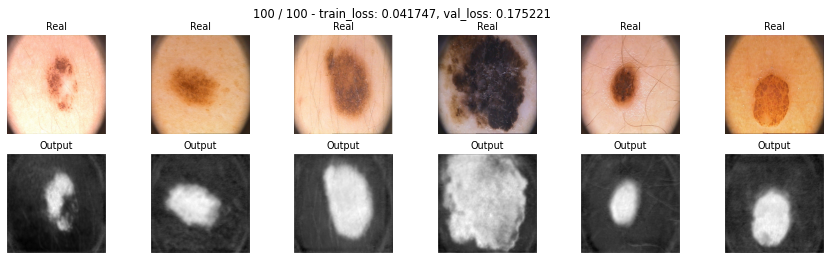

In [244]:
max_epochs = 100
optimaizer = optim.AdamW(unet_model.parameters(), lr=0.0001, weight_decay=0.02)
history["Unet+bce_loss"] = train(unet_model, optimaizer, bce_loss, max_epochs, data_tr, data_val, iou_pytorch)

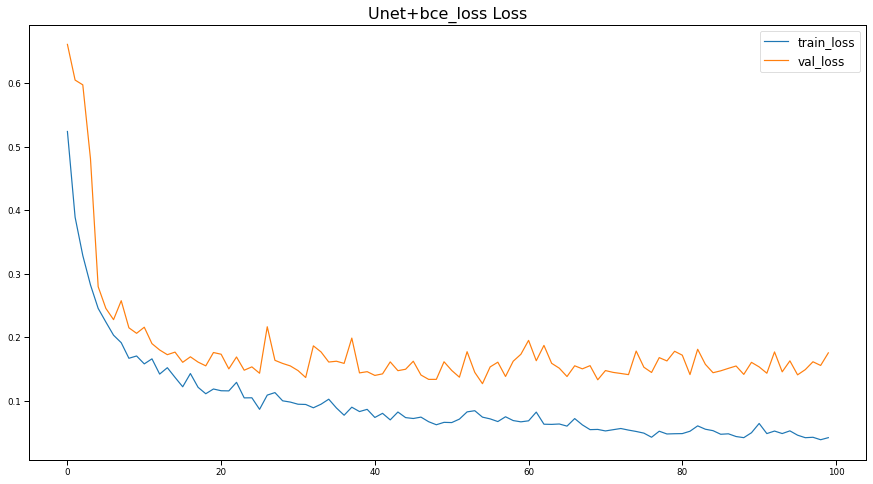

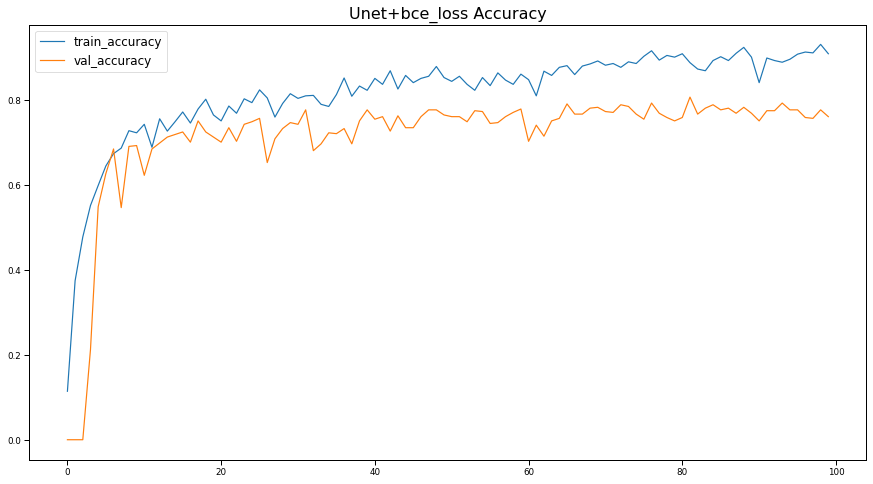

In [245]:
show_plot([history["Unet+bce_loss"][0], history["Unet+bce_loss"][1]], "Unet+bce_loss Loss", ["train_loss", "val_loss"])
show_plot([history["Unet+bce_loss"][2], history["Unet+bce_loss"][3]], "Unet+bce_loss Accuracy", ["train_accuracy", "val_accuracy"])

In [246]:
history_score["Unet+bce_loss"] = [score_model(unet_model, iou_pytorch, data_tr, if_show = False), 
                               score_model(unet_model, iou_pytorch, data_val, if_show = False), 
                               score_model(unet_model, iou_pytorch, data_ts, if_show = False)]

##Unet+dice_loss

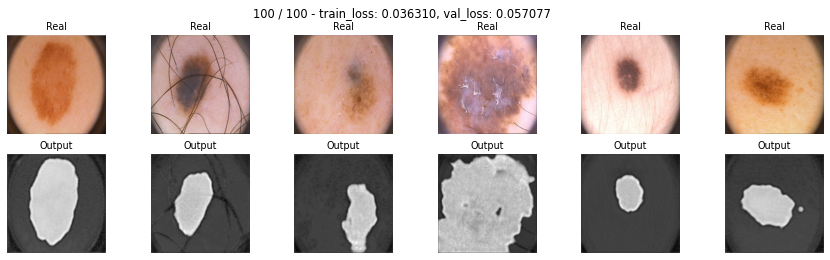

In [251]:
unet_model = UNet().to(device)
max_epochs = 100
optimaizer = optim.AdamW(unet_model.parameters(), lr=0.0001, weight_decay=0.02)
history["Unet+dice_loss"] = train(unet_model, optimaizer, dice_loss, max_epochs, data_tr, data_val, iou_pytorch)

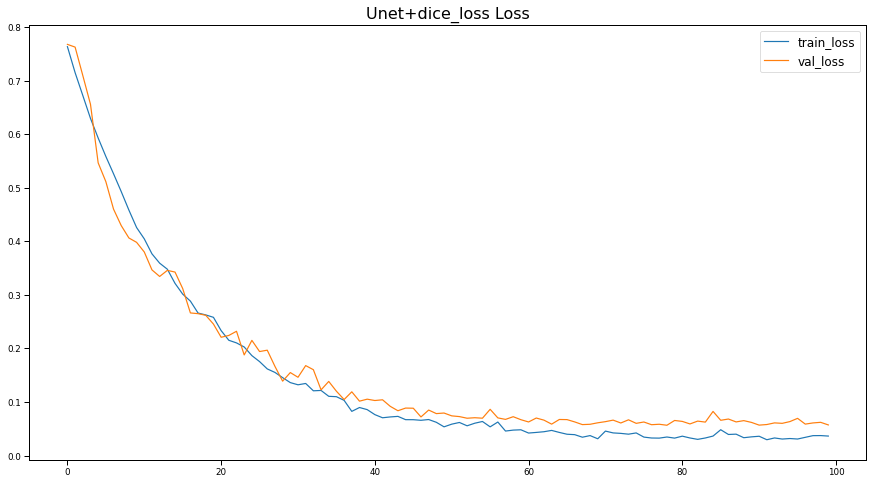

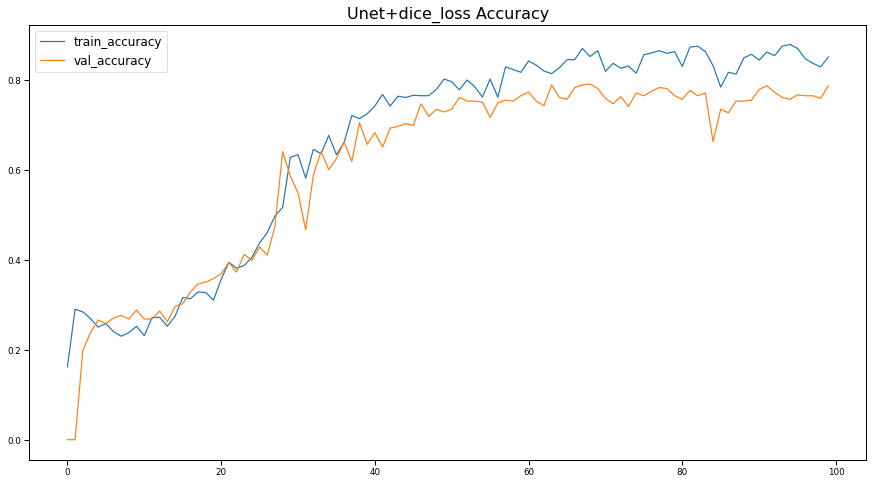

In [252]:
show_plot([history["Unet+dice_loss"][0], history["Unet+dice_loss"][1]], "Unet+dice_loss Loss", ["train_loss", "val_loss"])
show_plot([history["Unet+dice_loss"][2], history["Unet+dice_loss"][3]], "Unet+dice_loss Accuracy", ["train_accuracy", "val_accuracy"])

In [253]:
history_score["Unet+dice_loss"] = [score_model(unet_model, iou_pytorch, data_tr, if_show = False), 
                               score_model(unet_model, iou_pytorch, data_val, if_show = False), 
                               score_model(unet_model, iou_pytorch, data_ts, if_show = False)]

##Unet+focal_loss

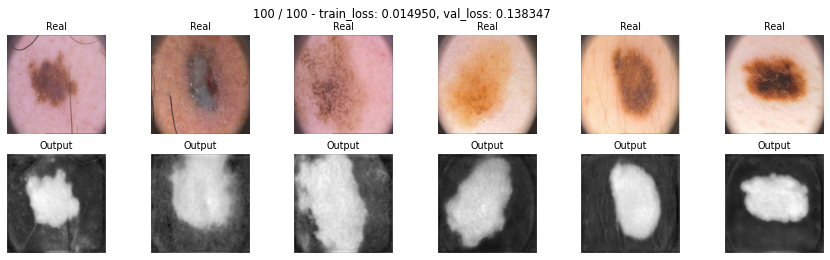

In [258]:
unet_model = UNet().to(device)
max_epochs = 100
optimaizer = optim.AdamW(unet_model.parameters(), lr=0.0001, weight_decay=0.02)
history["Unet+focal_loss"] = train(unet_model, optimaizer, focal_loss, max_epochs, data_tr, data_val, iou_pytorch)

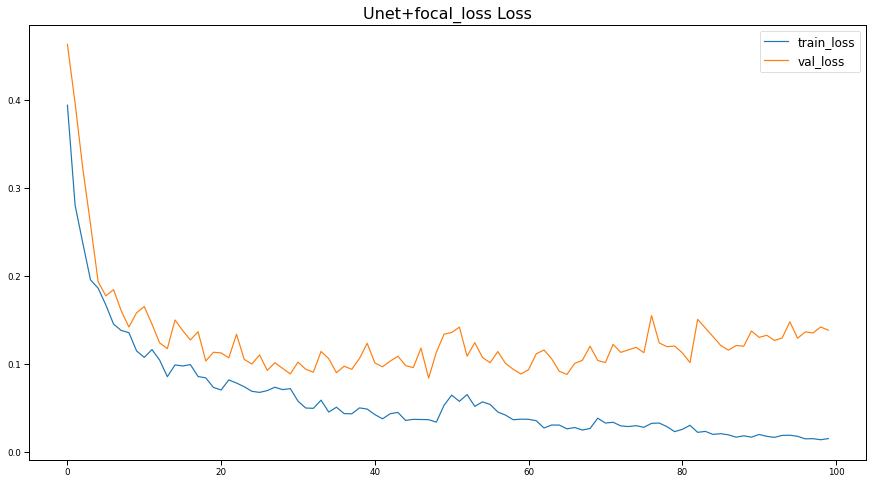

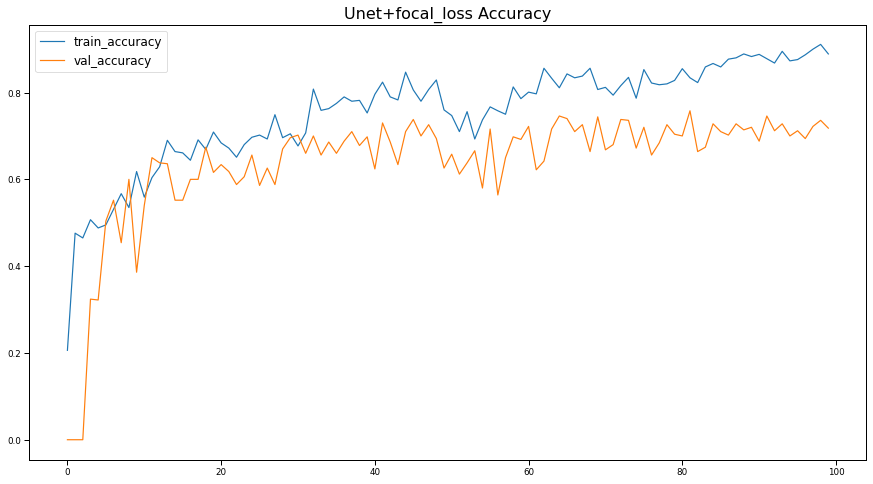

In [259]:
show_plot([history["Unet+focal_loss"][0], history["Unet+focal_loss"][1]], "Unet+focal_loss Loss", ["train_loss", "val_loss"])
show_plot([history["Unet+focal_loss"][2], history["Unet+focal_loss"][3]], "Unet+focal_loss Accuracy", ["train_accuracy", "val_accuracy"])

In [260]:
history_score["Unet+focal_loss"] = [score_model(unet_model, iou_pytorch, data_tr, if_show = False), 
                               score_model(unet_model, iou_pytorch, data_val, if_show = False), 
                               score_model(unet_model, iou_pytorch, data_ts, if_show = False)]

##Unet+L2_loss

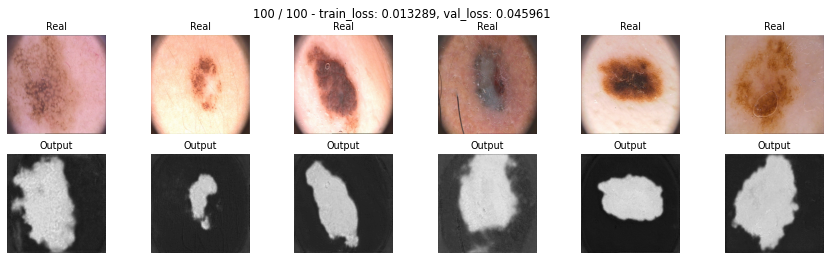

In [269]:
unet_model = UNet().to(device)
max_epochs = 100
optimaizer = optim.AdamW(unet_model.parameters(), lr=0.0001, weight_decay=0.02)
history["Unet+L2_loss"] = train(unet_model, optimaizer, L2_loss, max_epochs, data_tr, data_val, iou_pytorch)

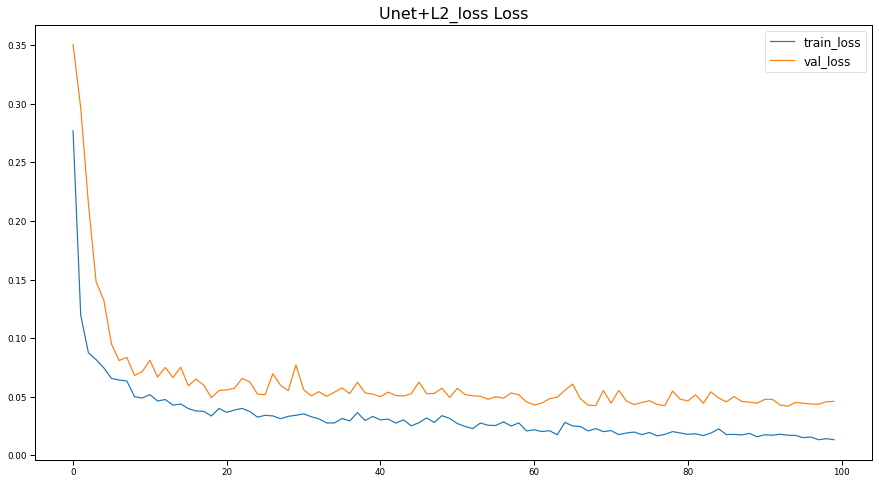

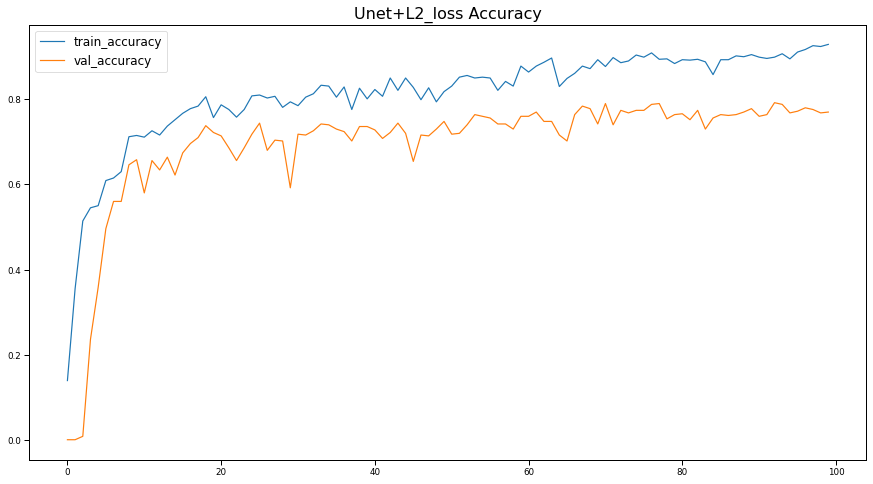

In [270]:
show_plot([history["Unet+L2_loss"][0], history["Unet+L2_loss"][1]], "Unet+L2_loss Loss", ["train_loss", "val_loss"])
show_plot([history["Unet+L2_loss"][2], history["Unet+L2_loss"][3]], "Unet+L2_loss Accuracy", ["train_accuracy", "val_accuracy"])

In [271]:
history_score["Unet+L2_loss"] = [score_model(unet_model, iou_pytorch, data_tr, if_show = False), 
                               score_model(unet_model, iou_pytorch, data_val, if_show = False), 
                               score_model(unet_model, iou_pytorch, data_ts, if_show = False)]

##Unet+HausdorffDT_loss

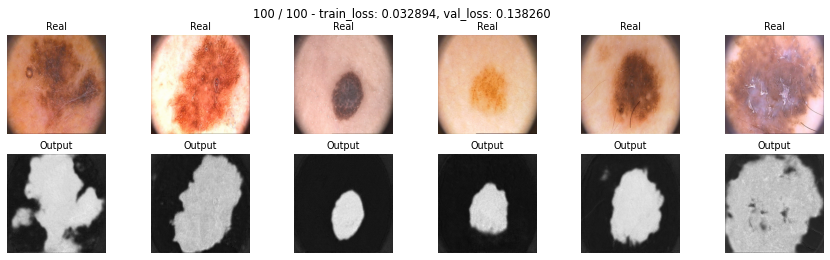

In [248]:
unet_model = UNet().to(device)
max_epochs = 100
optimaizer = optim.AdamW(unet_model.parameters(), lr=0.0001, weight_decay=0.02)
history["Unet+HausdorffDT_loss"] = train(unet_model, optimaizer, HausdorffDTLoss, max_epochs, data_tr, data_val, iou_pytorch)

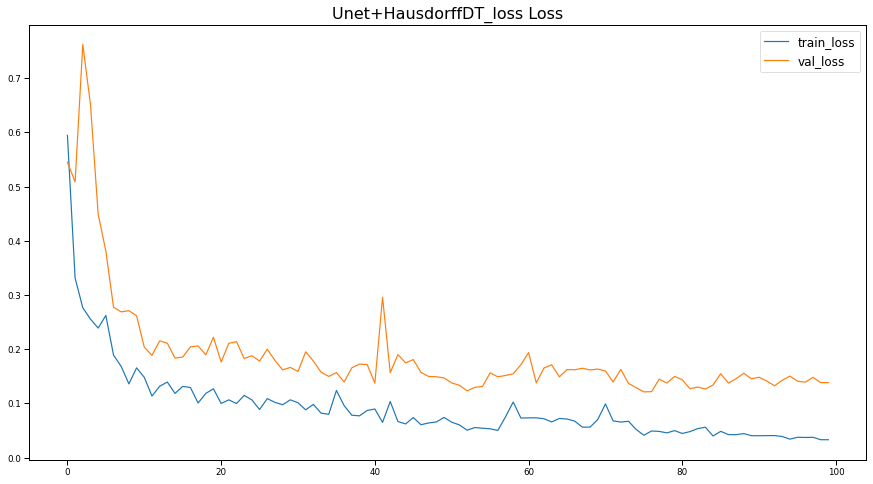

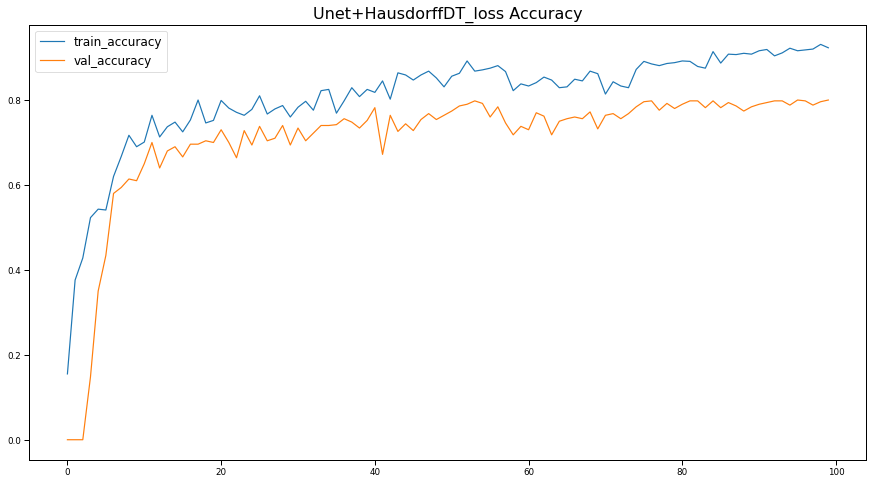

In [249]:
show_plot([history["Unet+HausdorffDT_loss"][0], history["Unet+HausdorffDT_loss"][1]], "Unet+HausdorffDT_loss Loss", ["train_loss", "val_loss"])
show_plot([history["Unet+HausdorffDT_loss"][2], history["Unet+HausdorffDT_loss"][3]], "Unet+HausdorffDT_loss Accuracy", ["train_accuracy", "val_accuracy"])

In [250]:
history_score["Unet+HausdorffDT_loss"] = [score_model(unet_model, iou_pytorch, data_tr, if_show = False), 
                               score_model(unet_model, iou_pytorch, data_val, if_show = False), 
                               score_model(unet_model, iou_pytorch, data_ts, if_show = False)]

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [277]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv0_1_bn = nn.BatchNorm2d(64)
        self.enc_conv0_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv0_2_bn = nn.BatchNorm2d(64)
        self.pool0 = nn.MaxPool2d(3,2, padding=1) # 256 -> 128
        
        self.enc_conv1_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(128)
        self.enc_conv1_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(3,2, padding=1) # 128 -> 64

        self.enc_conv2_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(256)
        self.enc_conv2_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(256)
        self.enc_conv2_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv2_3_bn = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(3,2, padding=1) # 64 -> 32

        self.enc_conv3_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(512)
        self.enc_conv3_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(512)
        self.enc_conv3_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(3,2, padding=1) # 32 -> 16

        self.enc_conv4_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.enc_conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.enc_conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(3,2, padding=1) # 16 -> 8

        # bottleneck
        # self.bottleneck_conv = 

        # decoder (upsampling)
        self.upsample4 = nn.Upsample(16)  # 8 -> 16
        self.dec_conv4_3 = nn.Conv2d (512, 512, 3, padding=1)
        self.dec_conv4_3_bn = nn.BatchNorm2d(512)
        self.dec_conv4_2 = nn.Conv2d (512, 512, 3, padding=1)
        self.dec_conv4_2_bn = nn.BatchNorm2d(512)
        self.dec_conv4_1 = nn.Conv2d (512, 512, 3, padding=1)
        self.dec_conv4_1_bn = nn.BatchNorm2d(512)

        self.upsample3 = nn.Upsample(32) # 16 -> 32
        self.dec_conv3_3 = nn.Conv2d (512, 512, 3, padding=1)
        self.dec_conv3_3_bn = nn.BatchNorm2d(512)
        self.dec_conv3_2 = nn.Conv2d (512, 512, 3, padding=1)
        self.dec_conv3_2_bn = nn.BatchNorm2d(512)
        self.dec_conv3_1 = nn.Conv2d (512, 256, 3, padding=1)
        self.dec_conv3_1_bn = nn.BatchNorm2d(256) 

        self.upsample2 = nn.Upsample(64) # 32 -> 64
        self.dec_conv2_3 = nn.Conv2d (256, 256, 3, padding=1)
        self.dec_conv2_3_bn = nn.BatchNorm2d(256)
        self.dec_conv2_2 = nn.Conv2d (256, 256, 3, padding=1)
        self.dec_conv2_2_bn = nn.BatchNorm2d(256)
        self.dec_conv2_1 = nn.Conv2d (256, 128, 3, padding=1)
        self.dec_conv2_1_bn = nn.BatchNorm2d(128) 

        self.upsample1 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv1_2 = nn.Conv2d (128, 128, 3, padding=1)
        self.dec_conv1_2_bn = nn.BatchNorm2d(128)
        self.dec_conv1_1 = nn.Conv2d (128, 64, 3, padding=1)
        self.dec_conv1_1_bn = nn.BatchNorm2d(64) 

        self.upsample0 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv0_2 = nn.Conv2d (64, 64, 3, padding=1)
        self.dec_conv0_2_bn = nn.BatchNorm2d(64)
        self.dec_conv0_1 = nn.Conv2d (64, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0_1 = F.relu(self.conv0_1_bn(self.enc_conv0_1(x)))
        sk_0 = F.relu(self.conv0_2_bn(self.enc_conv0_2(e0_1)))
        e0_2 = self.pool0(sk_0)

        e1_1 = F.relu(self.conv1_1_bn(self.enc_conv1_1(e0_2)))
        sk_1 = F.relu(self.conv1_2_bn(self.enc_conv1_2(e1_1)))
        e1_2 = self.pool1(sk_1)

        e2_1 = F.relu(self.conv2_1_bn(self.enc_conv2_1(e1_2)))
        e2_2 = F.relu(self.conv2_2_bn(self.enc_conv2_2(e2_1)))
        sk_2 = F.relu(self.conv2_3_bn(self.enc_conv2_3(e2_2)))
        e2_3 = self.pool2(sk_2)

        e3_1 = F.relu(self.conv3_1_bn(self.enc_conv3_1(e2_3)))
        e3_2 = F.relu(self.conv3_2_bn(self.enc_conv3_2(e3_1)))
        sk_3 = F.relu(self.conv3_3_bn(self.enc_conv3_3(e3_2)))
        e3_3 = self.pool3(sk_3)

        e4_1 = F.relu(self.conv4_1_bn(self.enc_conv4_1(e3_3)))
        e4_2 = F.relu(self.conv4_2_bn(self.enc_conv4_2(e4_1)))
        e4_3 = self.pool4(F.relu(self.conv4_3_bn(self.enc_conv4_3(e4_2))))


        # bottleneck
        # b = 

        # decoder

        d4_3 = F.relu(self.dec_conv4_3_bn(self.dec_conv4_3(self.upsample4(e4_3)))) 
        d4_2 = F.relu(self.dec_conv4_2_bn(self.dec_conv4_2(d4_3))) 
        d4_1 = F.relu(self.dec_conv4_1_bn(self.dec_conv4_1(d4_2))) 

        d3_3 = F.relu(self.dec_conv3_3_bn(self.dec_conv3_3(self.upsample3(d4_1)+sk_3))) 
        d3_2 = F.relu(self.dec_conv3_2_bn(self.dec_conv3_2(d3_3))) 
        d3_1 = F.relu(self.dec_conv3_1_bn(self.dec_conv3_1(d3_2))) 

        d2_3 = F.relu(self.dec_conv2_3_bn(self.dec_conv2_3(self.upsample2(d3_1)+sk_2))) 
        d2_2 = F.relu(self.dec_conv2_2_bn(self.dec_conv2_2(d2_3)))  
        d2_1 = F.relu(self.dec_conv2_1_bn(self.dec_conv2_1(d2_2)))  

        d1_2 = F.relu(self.dec_conv1_2_bn(self.dec_conv1_2(self.upsample1(d2_1)+sk_1))) 
        d1_1 = F.relu(self.dec_conv1_1_bn(self.dec_conv1_1(d1_2))) 

        d0_2 = F.relu(self.dec_conv0_2_bn(self.dec_conv0_2(self.upsample0(d1_1)+sk_0))) 
        d0_1 = self.dec_conv0_1(d0_2) # no activation and BatchNorm
        
        return d0_1

##Unet2+bce_loss

In [278]:
unet2_model = UNet2().to(device)

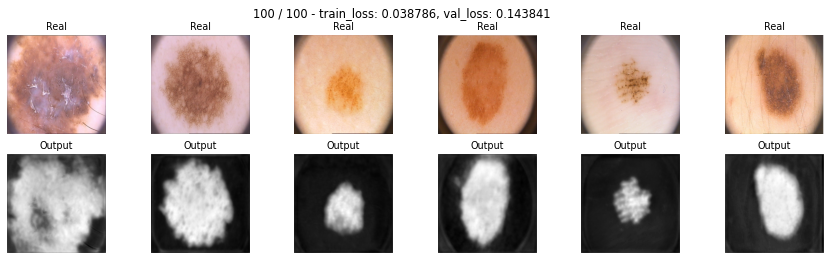

In [279]:
max_epochs = 100
optimaizer = optim.AdamW(unet2_model.parameters(), lr=0.0001, weight_decay=0.02)
history["Unet2+bce_loss"] = train(unet2_model, optimaizer, bce_loss, max_epochs, data_tr, data_val, iou_pytorch)

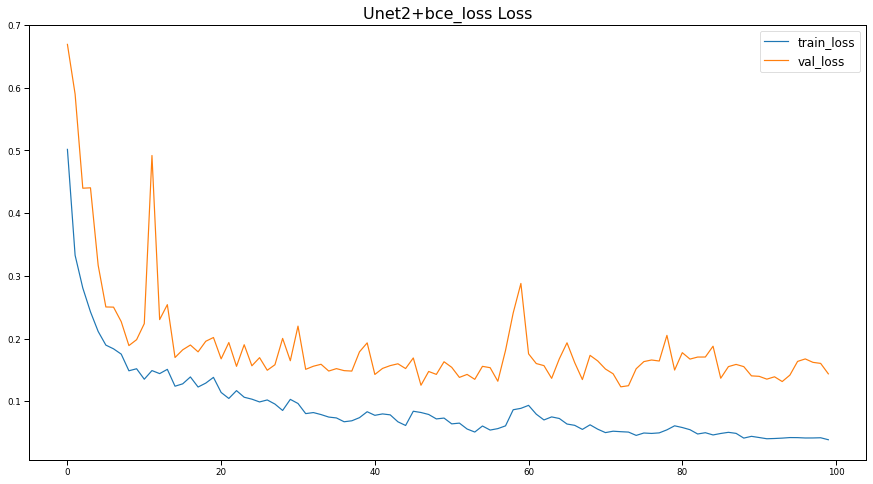

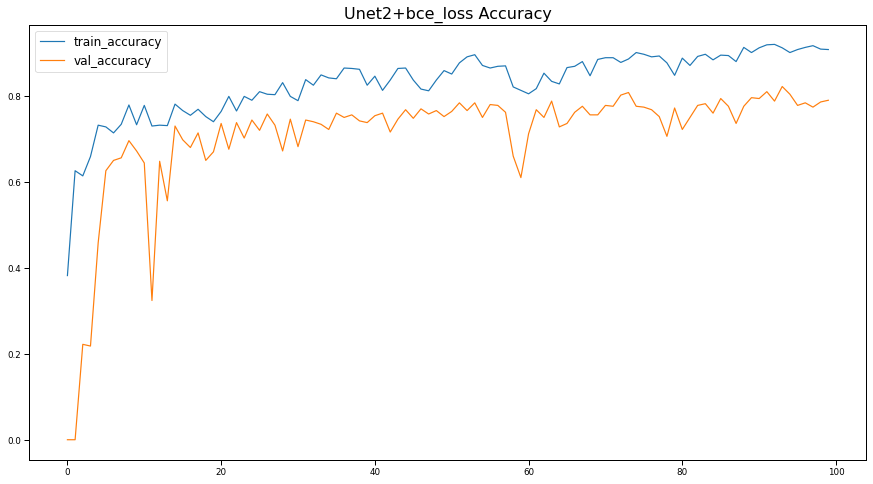

In [280]:
show_plot([history["Unet2+bce_loss"][0], history["Unet2+bce_loss"][1]], "Unet2+bce_loss Loss", ["train_loss", "val_loss"])
show_plot([history["Unet2+bce_loss"][2], history["Unet2+bce_loss"][3]], "Unet2+bce_loss Accuracy", ["train_accuracy", "val_accuracy"])

In [281]:
history_score["Unet2+bce_loss"] = [score_model(unet2_model, iou_pytorch, data_tr, if_show = False), 
                               score_model(unet2_model, iou_pytorch, data_val, if_show = False), 
                               score_model(unet2_model, iou_pytorch, data_ts, if_show = False)]

##Unet2+dice_loss

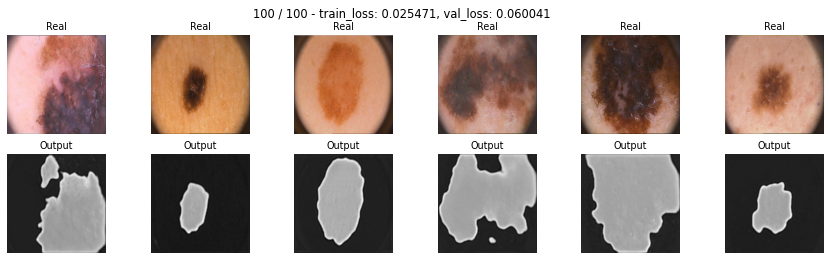

In [282]:
unet2_model = UNet2().to(device)
max_epochs = 100
optimaizer = optim.AdamW(unet2_model.parameters(), lr=0.0001, weight_decay=0.02)
history["Unet2+dice_loss"] = train(unet2_model, optimaizer, dice_loss, max_epochs, data_tr, data_val, iou_pytorch)

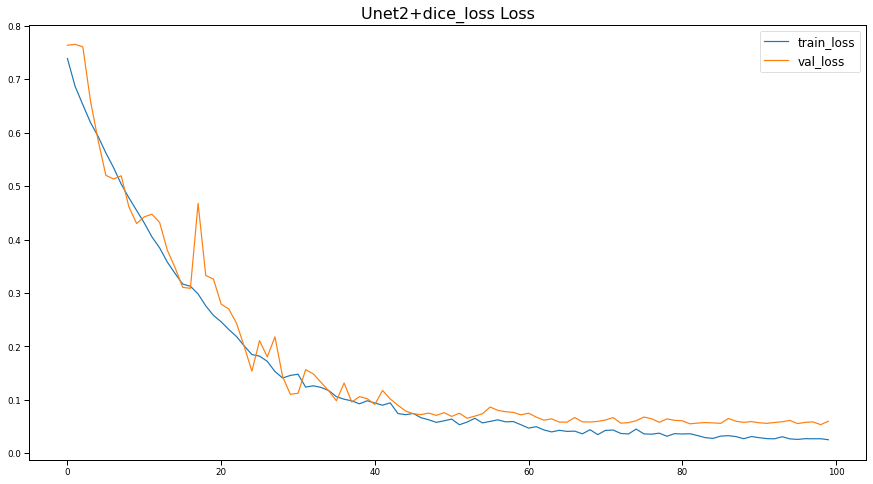

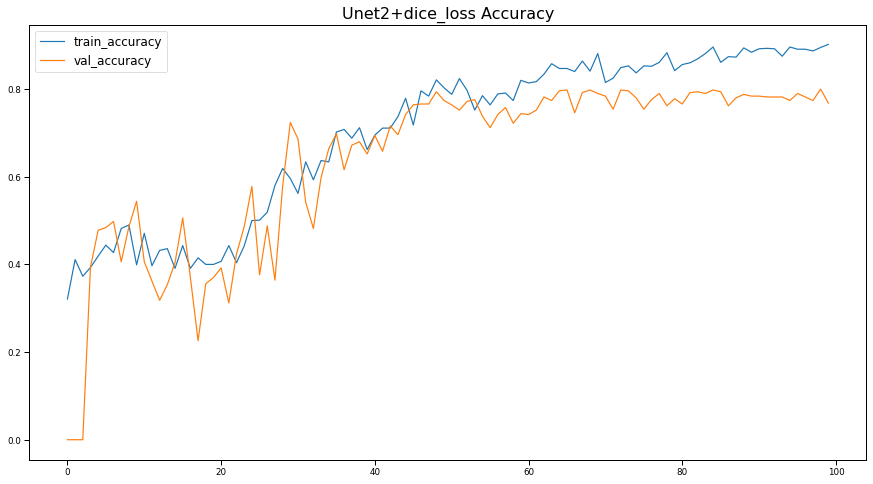

In [283]:
show_plot([history["Unet2+dice_loss"][0], history["Unet2+dice_loss"][1]], "Unet2+dice_loss Loss", ["train_loss", "val_loss"])
show_plot([history["Unet2+dice_loss"][2], history["Unet2+dice_loss"][3]], "Unet2+dice_loss Accuracy", ["train_accuracy", "val_accuracy"])

In [284]:
history_score["Unet2+dice_loss"] = [score_model(unet2_model, iou_pytorch, data_tr, if_show = False), 
                               score_model(unet2_model, iou_pytorch, data_val, if_show = False), 
                               score_model(unet2_model, iou_pytorch, data_ts, if_show = False)]

##Unet2+focal_loss

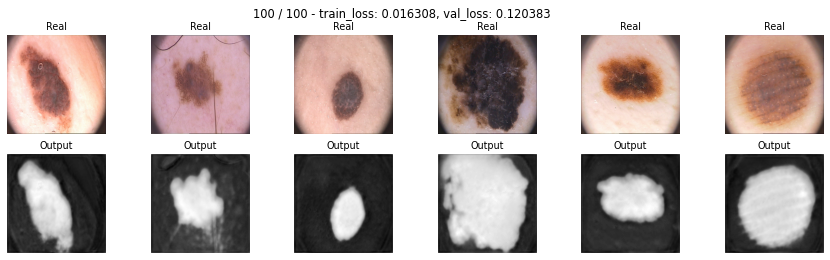

In [414]:
unet2_model = UNet2().to(device)
max_epochs = 100
optimaizer = optim.AdamW(unet2_model.parameters(), lr=0.0001, weight_decay=0.02)
history["Unet2+focal_loss"] = train(unet2_model, optimaizer, focal_loss, max_epochs, data_tr, data_val, iou_pytorch)

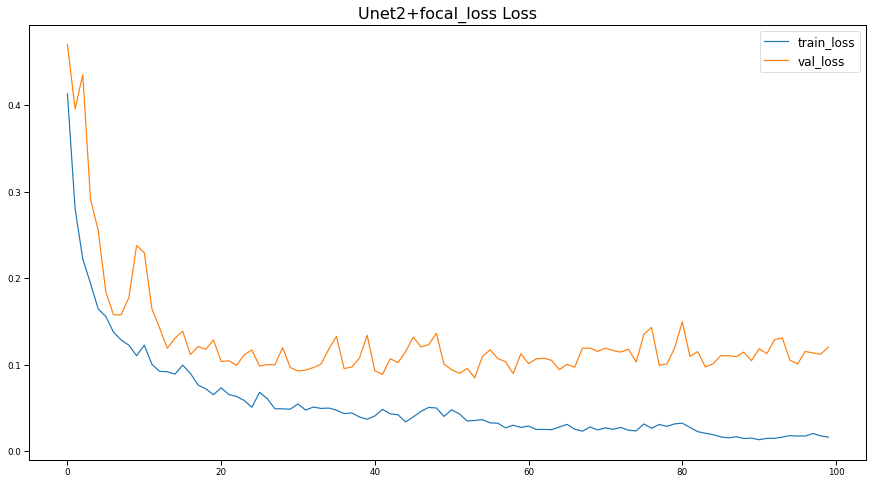

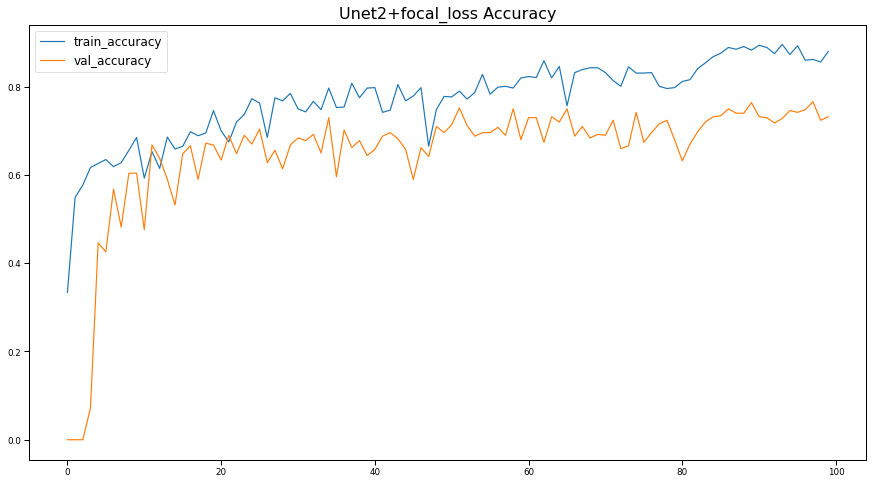

In [415]:
show_plot([history["Unet2+focal_loss"][0], history["Unet2+focal_loss"][1]], "Unet2+focal_loss Loss", ["train_loss", "val_loss"])
show_plot([history["Unet2+focal_loss"][2], history["Unet2+focal_loss"][3]], "Unet2+focal_loss Accuracy", ["train_accuracy", "val_accuracy"])

In [416]:
history_score["Unet2+focal_loss"] = [score_model(unet2_model, iou_pytorch, data_tr, if_show = False), 
                               score_model(unet2_model, iou_pytorch, data_val, if_show = False), 
                               score_model(unet2_model, iou_pytorch, data_ts, if_show = False)]

##Unet2+L2_loss

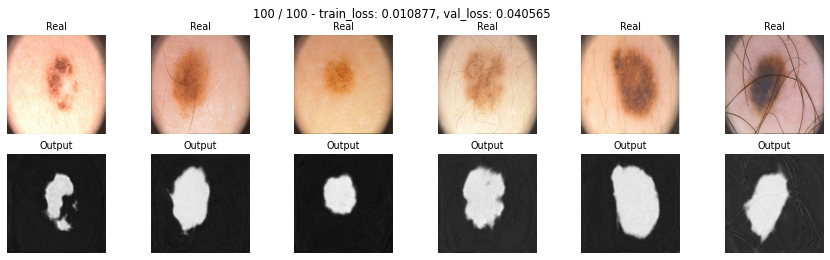

In [425]:
unet2_model = UNet2().to(device)
max_epochs = 100
optimaizer = optim.AdamW(unet2_model.parameters(), lr=0.0001, weight_decay=0.02)
history["Unet2+L2_loss"] = train(unet2_model, optimaizer, L2_loss, max_epochs, data_tr, data_val, iou_pytorch)

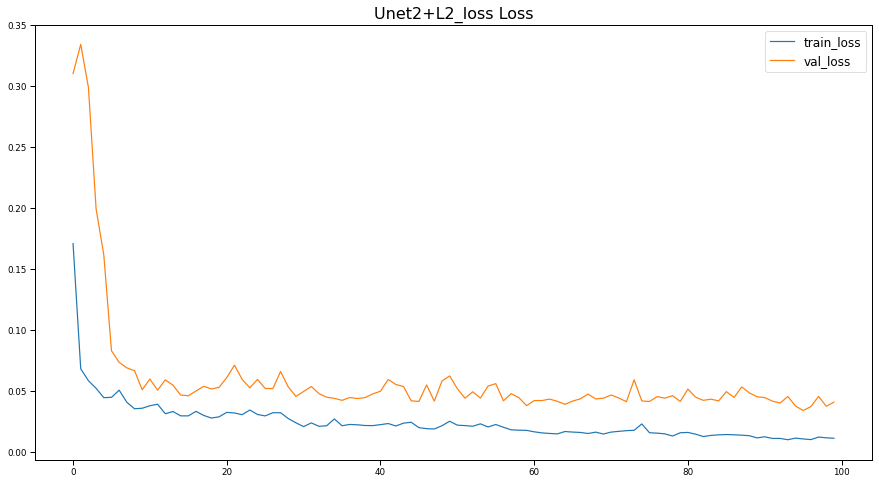

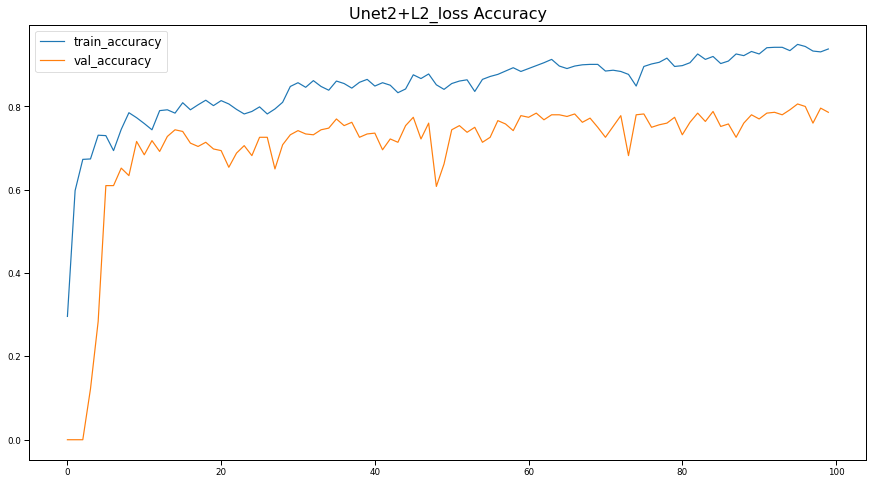

In [426]:
show_plot([history["Unet2+L2_loss"][0], history["Unet2+L2_loss"][1]], "Unet2+L2_loss Loss", ["train_loss", "val_loss"])
show_plot([history["Unet2+L2_loss"][2], history["Unet2+L2_loss"][3]], "Unet2+L2_loss Accuracy", ["train_accuracy", "val_accuracy"])

In [427]:
history_score["Unet2+L2_loss"] = [score_model(unet2_model, iou_pytorch, data_tr, if_show = False), 
                               score_model(unet2_model, iou_pytorch, data_val, if_show = False), 
                               score_model(unet2_model, iou_pytorch, data_ts, if_show = False)]

##Unet2+HausdorffDT_loss


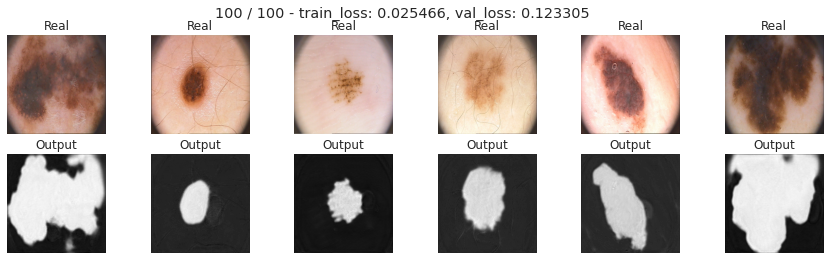

In [460]:
unet2_model = UNet2().to(device)
max_epochs = 100
optimaizer = optim.AdamW(unet2_model.parameters(), lr=0.0001, weight_decay=0.02)
history["Unet2+HausdorffDT_loss"] = train(unet2_model, optimaizer, HausdorffDTLoss, max_epochs, data_tr, data_val, iou_pytorch)

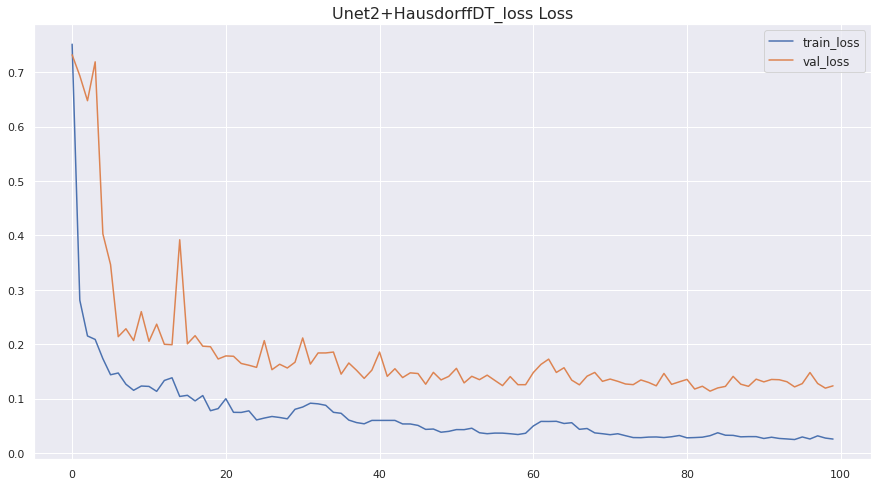

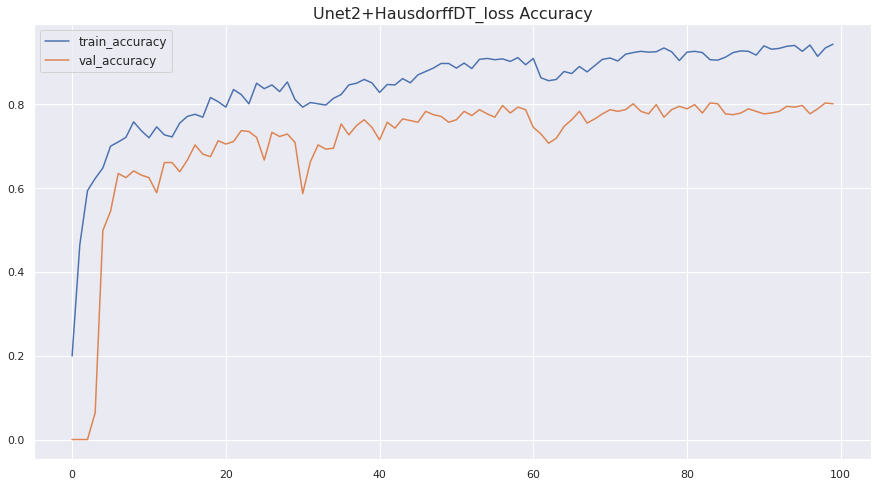

In [461]:
show_plot([history["Unet2+HausdorffDT_loss"][0], history["Unet2+HausdorffDT_loss"][1]], "Unet2+HausdorffDT_loss Loss", ["train_loss", "val_loss"])
show_plot([history["Unet2+HausdorffDT_loss"][2], history["Unet2+HausdorffDT_loss"][3]], "Unet2+HausdorffDT_loss Accuracy", ["train_accuracy", "val_accuracy"])

In [462]:
history_score["Unet2+HausdorffDT_loss"] = [score_model(unet2_model, iou_pytorch, data_tr, if_show = False), 
                               score_model(unet2_model, iou_pytorch, data_val, if_show = False), 
                               score_model(unet2_model, iou_pytorch, data_ts, if_show = False)]

Сделайте вывод какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

## SegNet Analysis

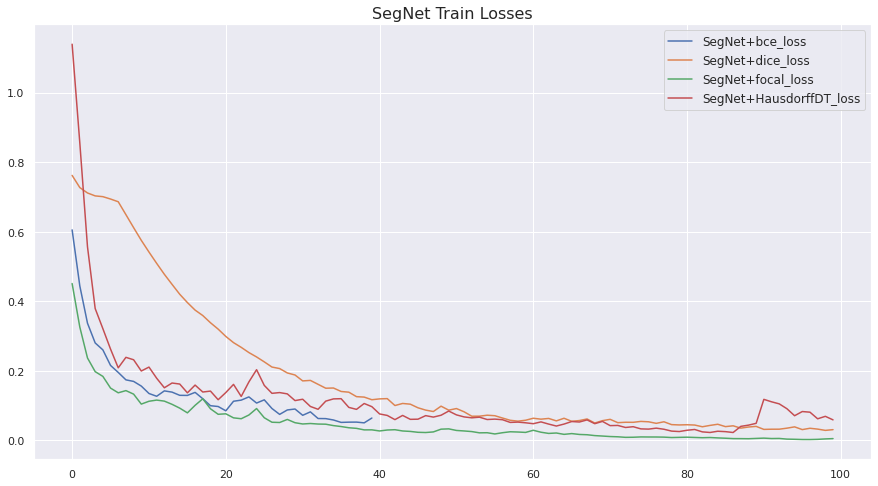

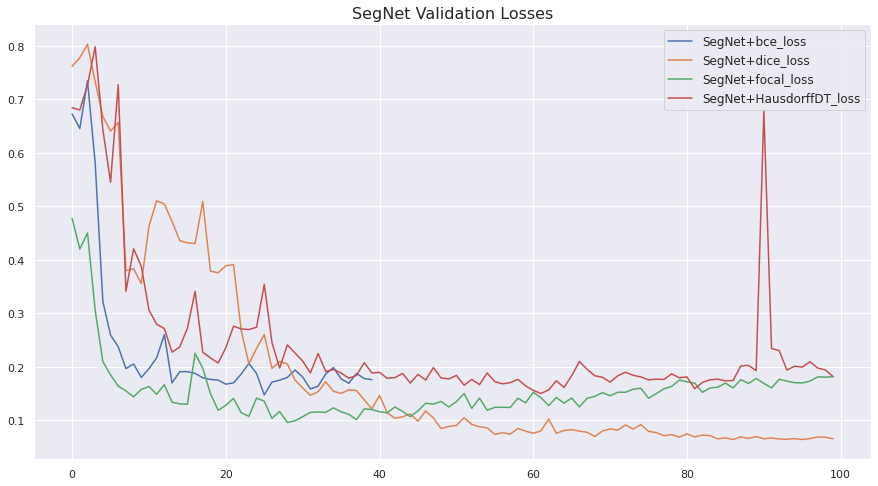

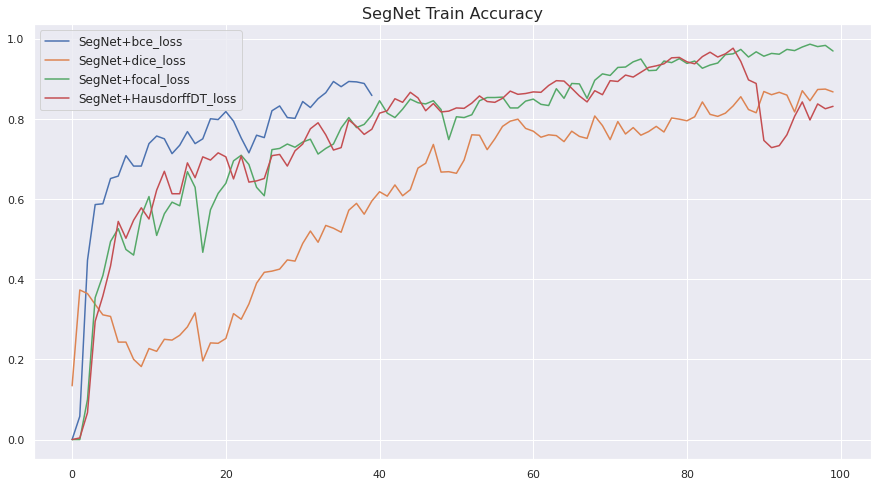

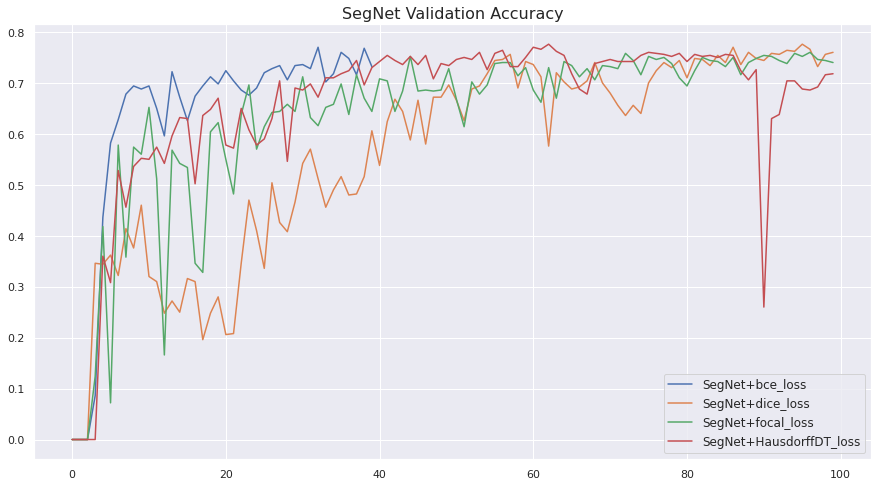

In [463]:
SegNet_keys = [key for key in history if "SegNet" in key]
SegNet_train_loss_hisoty = [history[key][0] for key in SegNet_keys] 
show_plot(SegNet_train_loss_hisoty, "SegNet Train Losses", SegNet_keys)
SegNet_validation_loss_hisoty = [history[key][1] for key in SegNet_keys] 
show_plot(SegNet_validation_loss_hisoty, "SegNet Validation Losses", SegNet_keys)
SegNet_train_acc_hisoty = [history[key][2] for key in SegNet_keys] 
show_plot(SegNet_train_acc_hisoty, "SegNet Train Accuracy", SegNet_keys)
SegNet_validation_acc_hisoty = [history[key][3] for key in SegNet_keys] 
show_plot(SegNet_validation_acc_hisoty, "SegNet Validation Accuracy", SegNet_keys)

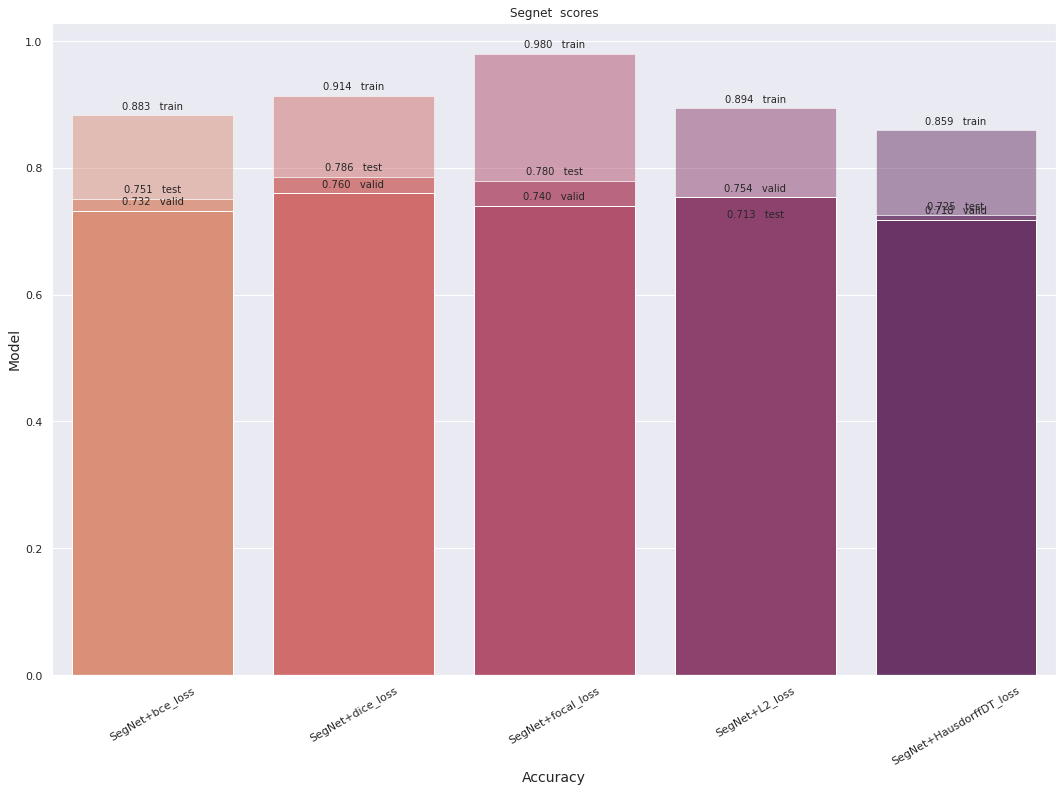

In [464]:
ShowBarPlot({key:history_score[key] for key in history_score if "SegNet" in key}, name_prefix="Segnet ")

## UNet Analysis

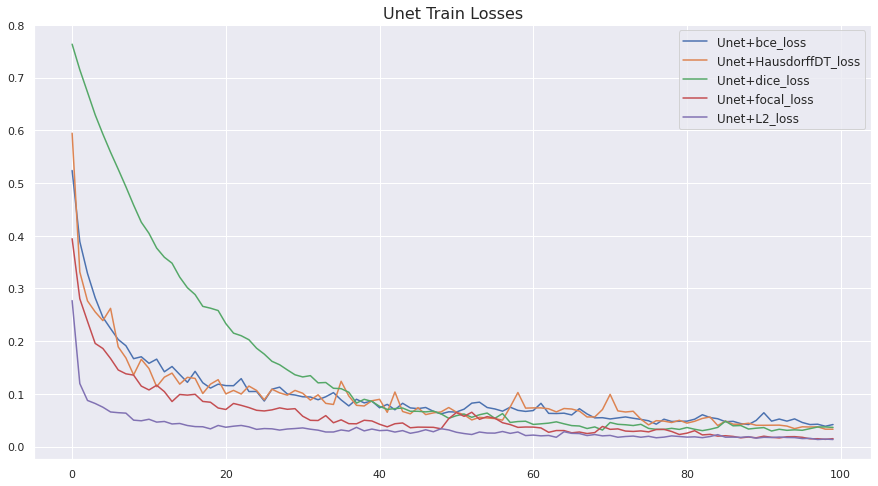

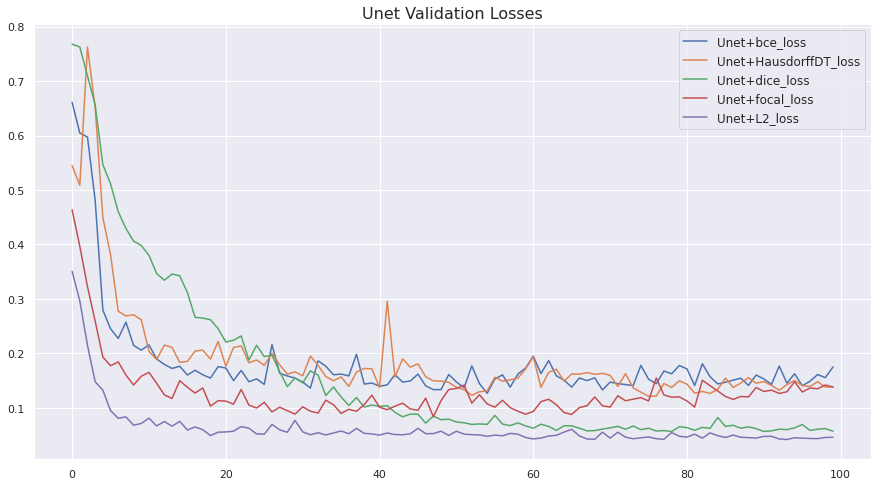

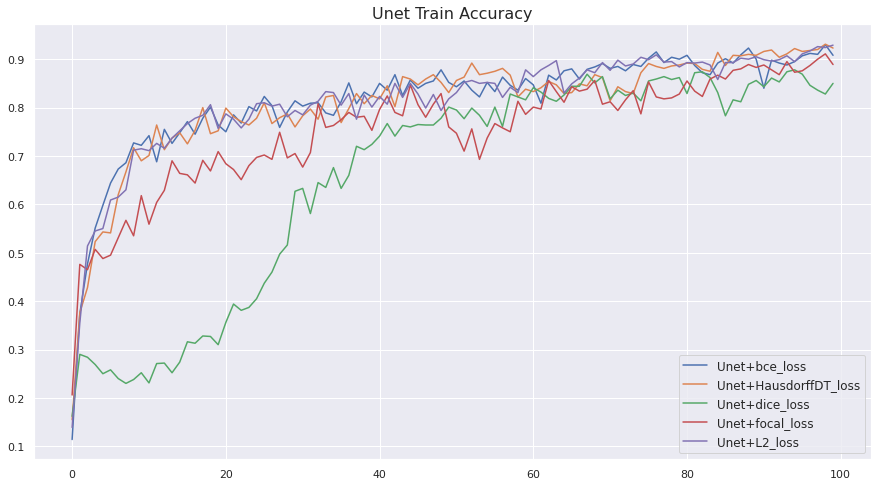

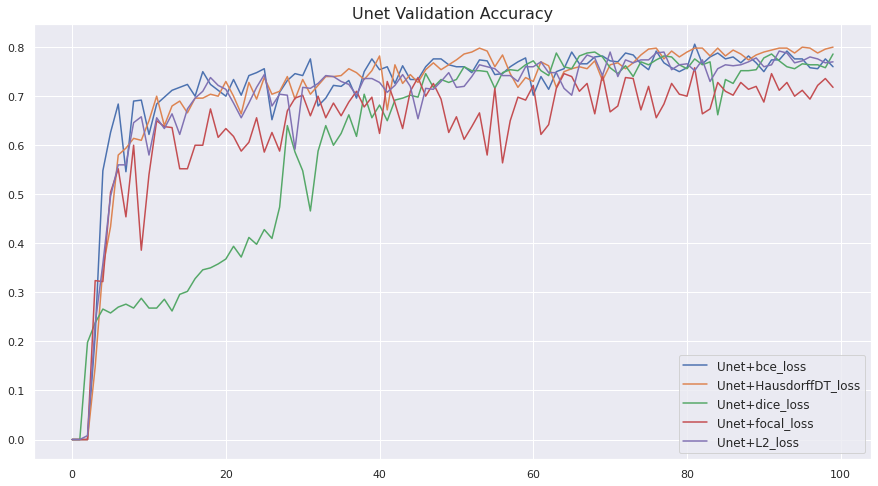

In [465]:
Unet_keys = [key for key in history if "Unet+" in key]
Unet_train_loss_hisoty = [history[key][0] for key in Unet_keys] 
show_plot(Unet_train_loss_hisoty, "Unet Train Losses", Unet_keys)
Unet_validation_loss_hisoty = [history[key][1] for key in Unet_keys] 
show_plot(Unet_validation_loss_hisoty, "Unet Validation Losses", Unet_keys)
Unet_train_acc_hisoty = [history[key][2] for key in Unet_keys] 
show_plot(Unet_train_acc_hisoty, "Unet Train Accuracy", Unet_keys)
Unet_validation_acc_hisoty = [history[key][3] for key in Unet_keys] 
show_plot(Unet_validation_acc_hisoty, "Unet Validation Accuracy", Unet_keys)

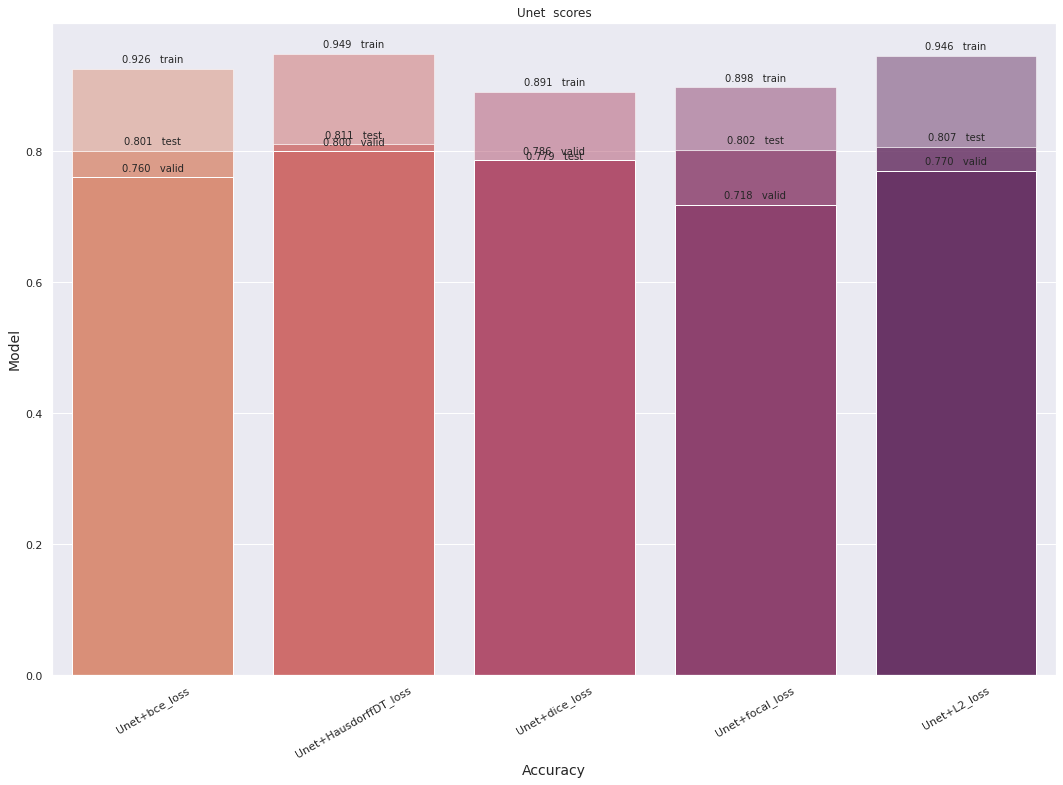

In [466]:
ShowBarPlot({key:history_score[key] for key in history_score if "Unet+" in key}, name_prefix="Unet ")

## UNet2 Analysis

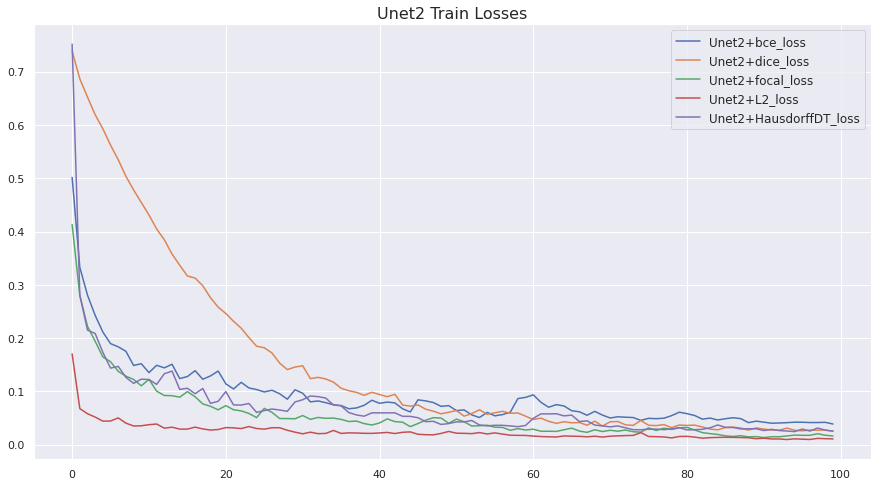

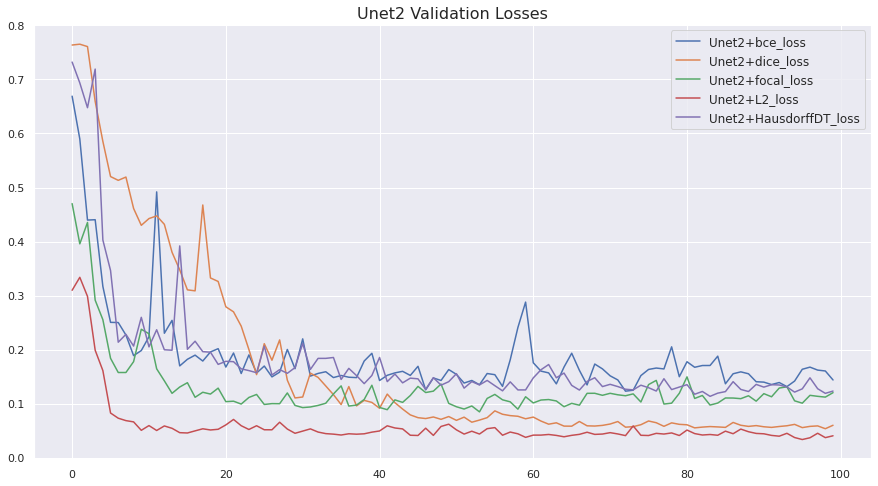

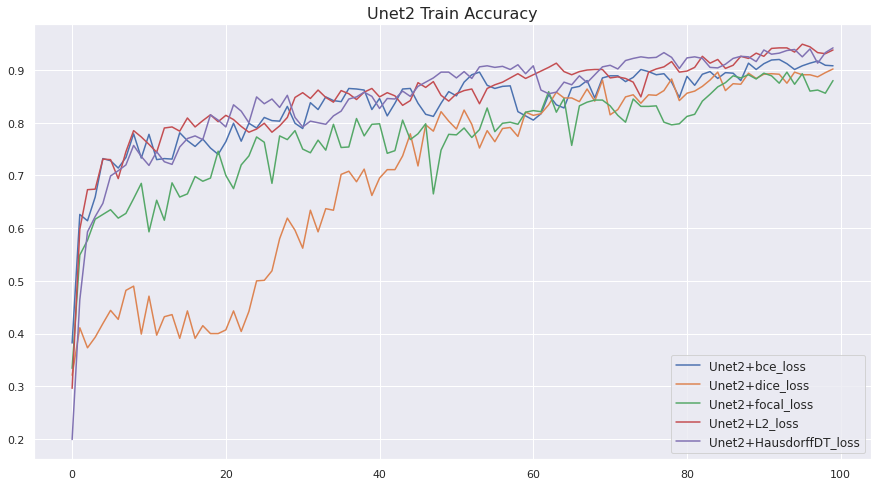

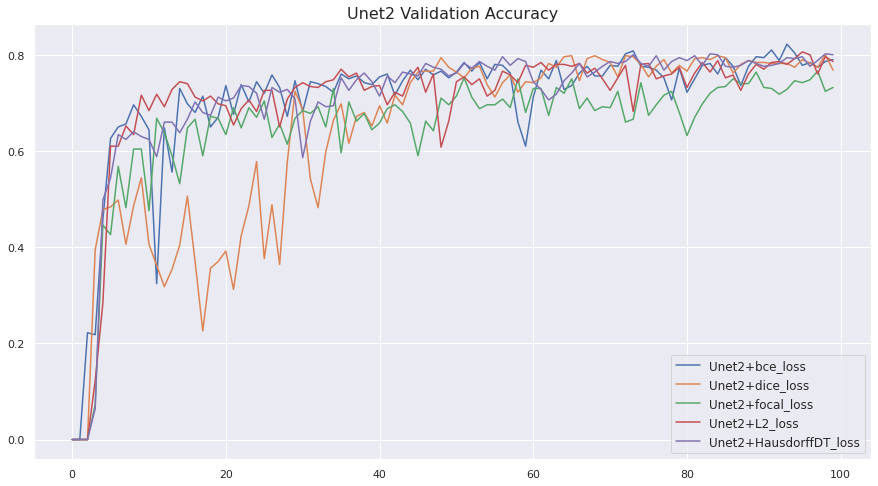

In [467]:
Unet2_keys = [key for key in history if "Unet2+" in key]
Unet2_train_loss_hisoty = [history[key][0] for key in Unet2_keys] 
show_plot(Unet2_train_loss_hisoty, "Unet2 Train Losses", Unet2_keys)
Unet2_validation_loss_hisoty = [history[key][1] for key in Unet2_keys] 
show_plot(Unet2_validation_loss_hisoty, "Unet2 Validation Losses", Unet2_keys)
Unet2_train_acc_hisoty = [history[key][2] for key in Unet2_keys] 
show_plot(Unet2_train_acc_hisoty, "Unet2 Train Accuracy", Unet2_keys)
Unet2_validation_acc_hisoty = [history[key][3] for key in Unet2_keys] 
show_plot(Unet2_validation_acc_hisoty, "Unet2 Validation Accuracy", Unet2_keys)

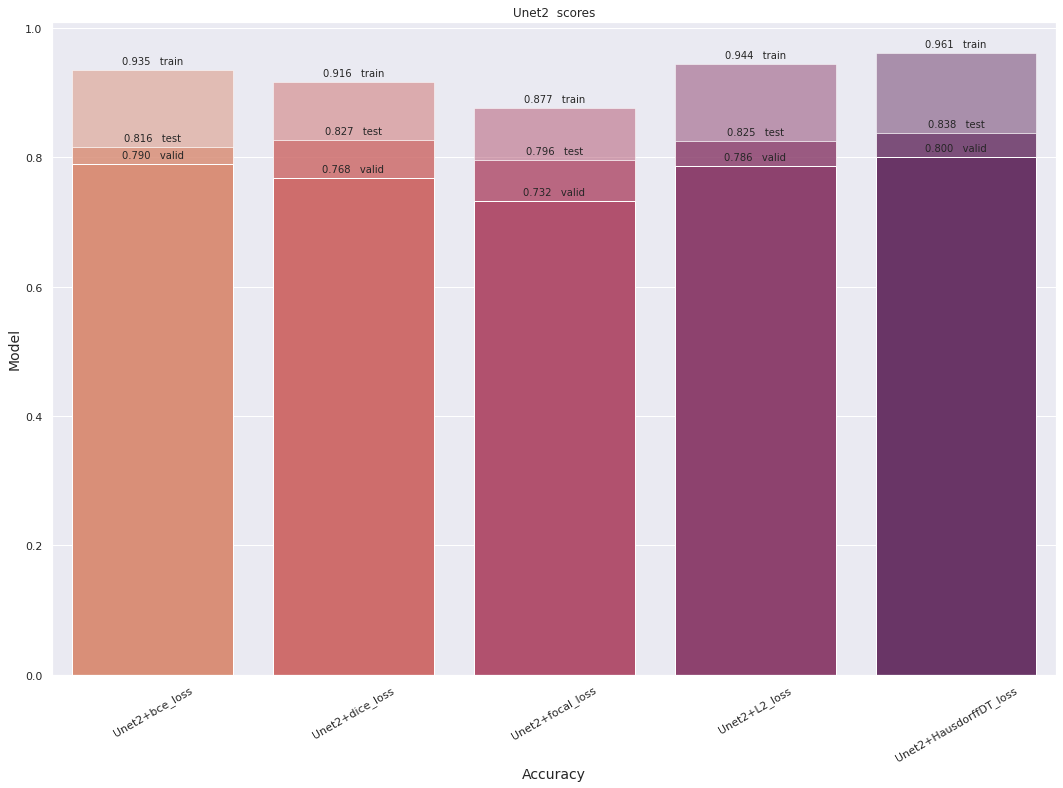

In [468]:
ShowBarPlot({key:history_score[key] for key in history_score if "Unet2+" in key}, name_prefix="Unet2 ")

## Total Analysis

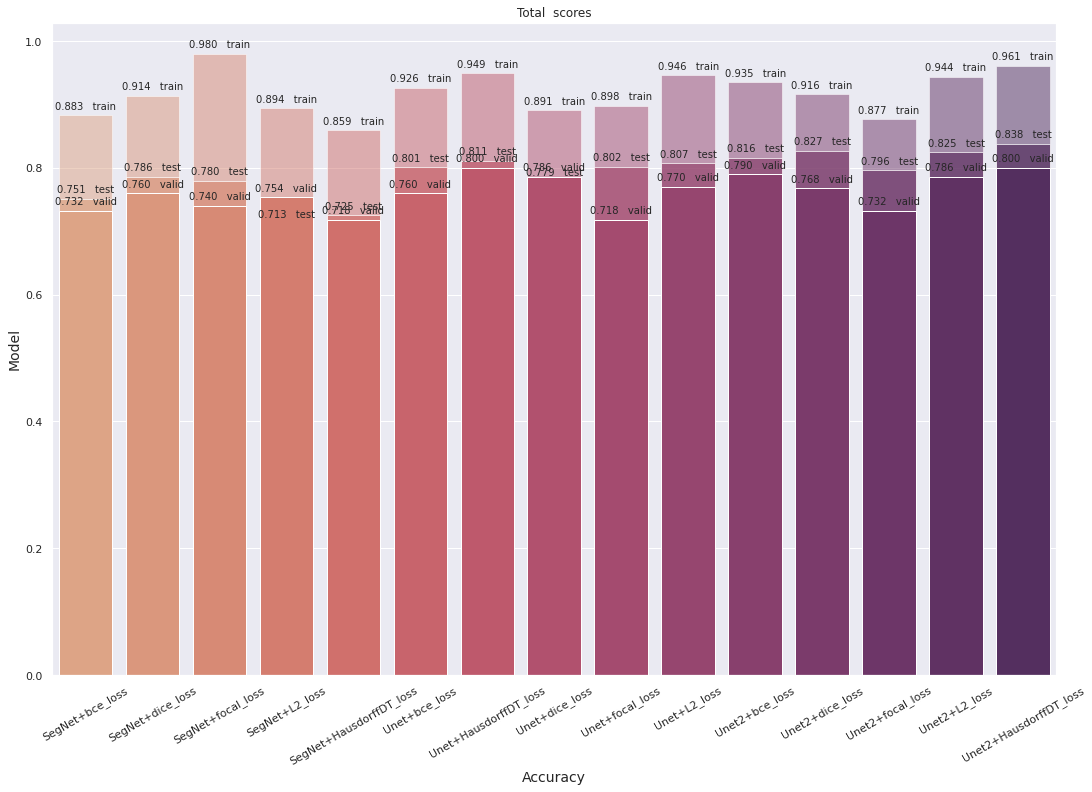

In [469]:
ShowBarPlot(history_score, name_prefix="Total ")

### Общие коментарии и выводы

К сожалению из-за маленького количества данных модель часто переобучается, что можно увидеть на соответствующих графиках (train-valid loss). 
Одним из решений в будущем может стать аугментация. Кроме неё:
  - добавить новых данных (сделать разметку руками) и проверить как работает (должно работать нормально)
  - использовать код повторно (лучше вынести в отдельные модули, особенно кусок обучение+построение графиком + сохранение history_score)
  - поработать над графиками 

По представленным графикам можно несложно выбрать лучший лосс для каждой модели, а также лучшую модель(выбирал по valid).
В моём случае это: Dice_loss для SegNet, HausdorffDT_loss для Unet и для Unet2. Лучший результат в это раз показала модель Unet2 с HausdorffDT_loss.

В целом этот вывод о лучшей модели является довольно формальным, по следующим причинам:
  1)качество будет зависить от исходного разбиения на выборки (частично спасает random.seed, но изменение его значение может изменить ранжирование моделей)
  2)качество будет зависить от гиперпараметров моделей. Можно искать оптимальные для каждой модели. Мной были выбраны относительно неплохие. Но очевидно, что можно лучше
  (как минимум уменьшить количество эпох и в некоторых случаях не переобучать модель)

Стоит отметить высокую конкурирующую способность обычного L2 лосса. Таким образом можно подтвердить известный вывод, что в большинстве случаев надо начинать с простого.